In [84]:
%matplotlib inline

import os

import torch
import gpytorch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
from rdkit.Chem.Fingerprints import FingerprintMols
from MDAnalysis.analysis.rms import rmsd
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from map4 import MAP4Calculator
import tmap as tm


from mobius import ForceField, VirtualTarget

# Read MHC-I dataset

In [60]:
data = []
temperature = 300.
RT = 0.001987 * temperature

with open('binding_data_2013/bdata.20130222.mhci.txt') as f:
    lines = f.readlines()
    
    for line in lines[1:]:
        sline = line.split()
        data.append((sline[0], sline[1], int(sline[2]), sline[3], sline[4], float(sline[5])))

columns = ['species', 'mhc_allele', 'length', 'sequence', 'inequality', 'affinity_binding']
mhci = pd.DataFrame(data=data, columns=columns)

# Convert affinity binding (nM) in energy interaction (kcal/mol)
mhci['energy'] = RT * np.log(mhci['affinity_binding'] * 1e-9)

mhci.to_csv('binding_data_2013/bdata.20130222.mhci.csv', index=False)

In [2]:
mhci = pd.read_csv('binding_data_2013/bdata.20130222.mhci.csv')

In [5]:
for name, group in mhci[mhci['species'] == 'human'].groupby('mhc_allele'):
    print(name, len(group))

HLA-A*01:01 4792
HLA-A*02:01 12160
HLA-A*02:02 4155
HLA-A*02:03 6303
HLA-A*02:04 4
HLA-A*02:05 75
HLA-A*02:06 5628
HLA-A*02:07 80
HLA-A*02:10 18
HLA-A*02:11 1085
HLA-A*02:12 1183
HLA-A*02:16 921
HLA-A*02:17 346
HLA-A*02:19 1246
HLA-A*02:50 135
HLA-A*03:01 7358
HLA-A*03:02 26
HLA-A*03:19 30
HLA-A*11:01 6399
HLA-A*11:02 14
HLA-A*23:01 2641
HLA-A*24:02 3280
HLA-A*24:03 1381
HLA-A*25:01 960
HLA-A*26:01 4535
HLA-A*26:02 643
HLA-A*26:03 537
HLA-A*29:02 2789
HLA-A*30:01 2925
HLA-A*30:02 2057
HLA-A*31:01 5713
HLA-A*32:01 1136
HLA-A*32:07 88
HLA-A*32:15 74
HLA-A*33:01 3597
HLA-A*66:01 219
HLA-A*68:01 3795
HLA-A*68:02 5545
HLA-A*68:23 82
HLA-A*69:01 2565
HLA-A*74:01 15
HLA-A*80:01 1171
HLA-A1 1
HLA-A11 74
HLA-A2 63
HLA-A24 2
HLA-A26 4
HLA-A3 6
HLA-A3/11 2
HLA-B*07:02 4642
HLA-B*08:01 3538
HLA-B*08:02 1020
HLA-B*08:03 470
HLA-B*14:01 42
HLA-B*14:02 341
HLA-B*15:01 4448
HLA-B*15:02 164
HLA-B*15:03 701
HLA-B*15:09 832
HLA-B*15:17 1447
HLA-B*15:42 364
HLA-B*18:01 2832
HLA-B*27:01 4
HLA-B*27:02 8
HLA

# HLA-A*02:01

## Exploration

(7.0, 15.0)

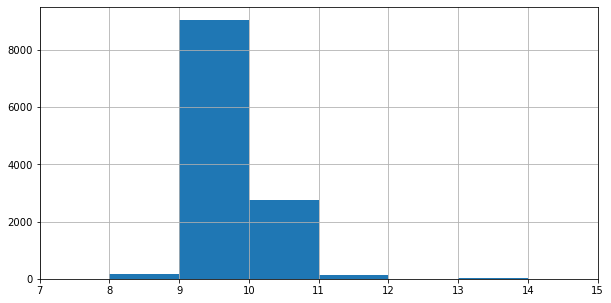

In [25]:
fig, ax = plt.subplots(figsize=(10, 5))
mhci[mhci['mhc_allele'] == 'HLA-A*02:01']['length'].hist(ax=ax, bins=range(7, 15))
ax.set_xlim([7, 15])
plt.show()

(0.0, 200.0)

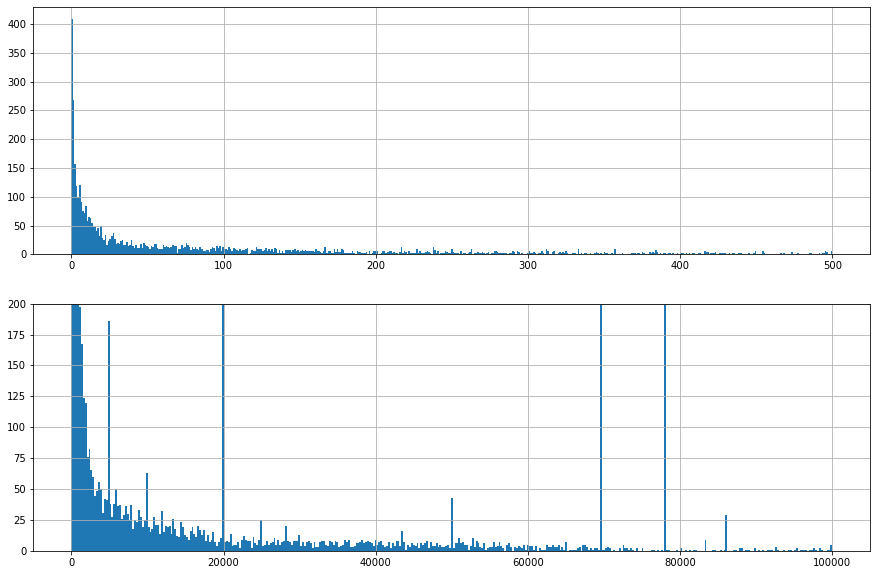

In [26]:
fig, axarr = plt.subplots(2, 1, figsize=(15, 10))
mhci[mhci['mhc_allele'] == 'HLA-A*02:01']['affinity_binding'].hist(ax=axarr[0], bins=np.linspace(0, 500, 500))
mhci[mhci['mhc_allele'] == 'HLA-A*02:01']['affinity_binding'].hist(ax=axarr[1], bins=np.linspace(0, 100000, 400))
axarr[1].set_ylim((0, 200))
plt.show()

<AxesSubplot:>

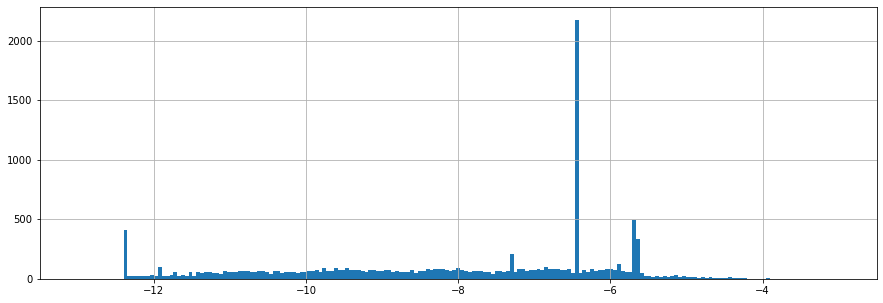

In [72]:
fig, ax = plt.subplots(figsize=(15, 5))
mhci[mhci['mhc_allele'] == 'HLA-A*02:01']['energy'].hist(ax=ax, bins=np.linspace(-13, -3, 200))
plt.show()

In [28]:
# We removed those binding affinity values
# A lot of peptides were set with those values. Looks like some default values assigned...
dirty_values = [1, 2, 3, 5000, 10000, 20000, 43424, 50000, 69444.44444, 78125]

# Split dataset in training and testing sets
selected = mhci[(mhci['mhc_allele'] == 'HLA-A*02:01') &
                (mhci['length'] == 9) &
                (~mhci['affinity_binding'].isin(dirty_values))]
X_train, X_test, y_train, y_test = train_test_split(selected['sequence'], selected['energy'], test_size=0.3)

print(X_train.shape, X_test.shape)

y_train = torch.from_numpy(y_train.values).float()
y_test = torch.from_numpy(y_test.values).float()

(4076,) (1747,)


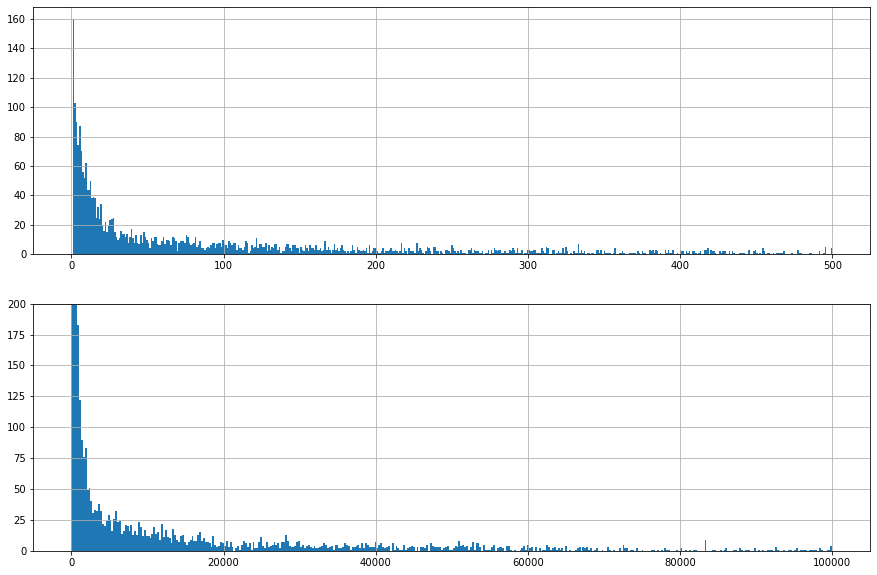

In [64]:
fig, axarr = plt.subplots(2, 1, figsize=(15, 10))
selected['affinity_binding'].hist(ax=axarr[0], bins=np.linspace(0, 500, 500))
selected['affinity_binding'].hist(ax=axarr[1], bins=np.linspace(0, 100000, 400))
axarr[1].set_ylim((0, 200))
plt.show()

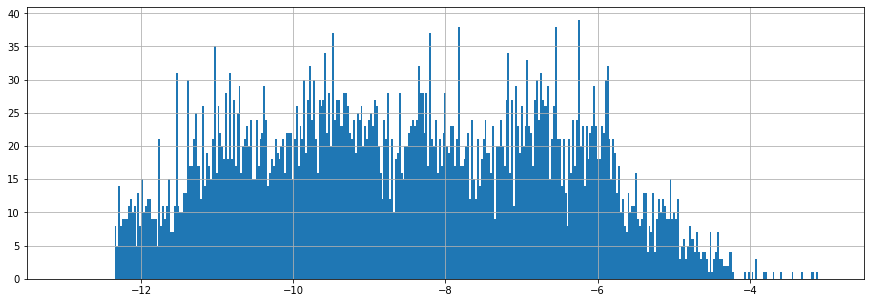

In [65]:
fig, ax = plt.subplots(figsize=(15, 5))
selected['energy'].hist(ax=ax, bins=np.linspace(-13, -3, 400))
plt.show()

## Training (with RBF Kernel)

In [3]:
def transform(sequences, scale):    
    transformed = []
    
    for seq in sequences:
        tmp = []

        for aa in seq:
            tmp.extend(scale[scale['AA1'] == aa].values[0][2:])

        transformed.append(tmp)
        
    return torch.from_numpy(np.array(transformed)).float()

    
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        #self.covar_module = SequenceKernel()

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    
    
# Wrap training, prediction and plotting from the ExactGP-Tutorial into a function,
# so that we do not have to repeat the code later on
def train(model, likelihood, train_x, train_y, training_iter=100):
    # Find optimal model hyperparameters
    model.train()
    likelihood.train()

    # Use the adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    for i in range(training_iter):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(train_x)
        # Calc loss and backprop gradients
        loss = -mll(output, train_y)
        loss.backward()
        
        print('Iter %02d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
            i + 1, training_iter, loss.item(),
            model.covar_module.base_kernel.lengthscale.item(),
            model.likelihood.noise.item()
        ))
        
        optimizer.step()

In [26]:
def predict(model, likelihood, test_x):
    model.eval()
    likelihood.eval()
    
    # Make predictions by feeding model through likelihood
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        # Test points are regularly spaced along [0,1]
        return likelihood(model(test_x))


def plot(y_test, observed_pred, fig_filename=None):
    with torch.no_grad():
        fig, ax = plt.subplots(1, 1, figsize=(10, 10))
        
        ax.scatter(y_test, observed_pred)
        
        ax.set_ylim([np.min([y_test, observed_pred]) - 1, np.max([y_test, observed_pred]) + 1])
        ax.set_xlabel('Experimental values (kcal/mol)', fontsize=20)
        ax.set_ylabel('Predicted values (kcal/mol)', fontsize=20)
        
        if fig_filename is not None:
            plt.savefig(fig_filename, bbox_inches='tight', dpi=300)
        
        plt.show()

### Extended Z-scale descriptors + RBF kernel

In [346]:
# Transform sequence into tensor using amino acid scales
# ISA-ECI, z-scale, extended z-scale, DDPS from Zhou 2010 (10.1007/s00726-008-0228-1)
# extended DPPS from Zhou 2008 (10.1002/bip.21091)
descriptors = pd.read_csv('extended_z_scale.csv')

X_train_transformed = transform(X_train, descriptors)
X_test_transformed = transform(X_test, descriptors)

In [347]:
# Initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(X_train_transformed, y_train, likelihood)

# Train GP model
train(model, likelihood, X_train_transformed, y_train, training_iter=1000)

/home/eberhardt/Applications/miniconda3/envs/mm/lib/python3.9/site-packages/gpytorch/utils/linear_cg.py:234: UserWarning: An output with one or more elements was resized since it had shape [11], which does not match the required output shape [1, 11].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  ../aten/src/ATen/native/Resize.cpp:23.)
  torch.sum(mul_storage, -2, keepdim=True, out=alpha)


Iter 01/1000 - Loss: 28.600   lengthscale: 0.693   noise: 0.693
Iter 02/1000 - Loss: 26.163   lengthscale: 0.744   noise: 0.744
Iter 03/1000 - Loss: 23.987   lengthscale: 0.798   noise: 0.798
Iter 04/1000 - Loss: 22.047   lengthscale: 0.855   noise: 0.853
Iter 05/1000 - Loss: 20.317   lengthscale: 0.913   noise: 0.911
Iter 06/1000 - Loss: 18.775   lengthscale: 0.975   noise: 0.969
Iter 07/1000 - Loss: 17.402   lengthscale: 1.039   noise: 1.029
Iter 08/1000 - Loss: 16.177   lengthscale: 1.105   noise: 1.090
Iter 09/1000 - Loss: 15.085   lengthscale: 1.174   noise: 1.151
Iter 10/1000 - Loss: 14.108   lengthscale: 1.244   noise: 1.212
Iter 11/1000 - Loss: 13.235   lengthscale: 1.318   noise: 1.274
Iter 12/1000 - Loss: 12.451   lengthscale: 1.393   noise: 1.335
Iter 13/1000 - Loss: 11.748   lengthscale: 1.470   noise: 1.396
Iter 14/1000 - Loss: 11.115   lengthscale: 1.549   noise: 1.456
Iter 15/1000 - Loss: 10.544   lengthscale: 1.629   noise: 1.515
Iter 16/1000 - Loss: 10.027   lengthscal

Iter 131/1000 - Loss: 1.899   lengthscale: 7.152   noise: 2.489
Iter 132/1000 - Loss: 1.899   lengthscale: 7.162   noise: 2.486
Iter 133/1000 - Loss: 1.898   lengthscale: 7.173   noise: 2.482
Iter 134/1000 - Loss: 1.896   lengthscale: 7.183   noise: 2.479
Iter 135/1000 - Loss: 1.897   lengthscale: 7.194   noise: 2.476
Iter 136/1000 - Loss: 1.898   lengthscale: 7.205   noise: 2.473
Iter 137/1000 - Loss: 1.893   lengthscale: 7.215   noise: 2.470
Iter 138/1000 - Loss: 1.894   lengthscale: 7.226   noise: 2.466
Iter 139/1000 - Loss: 1.892   lengthscale: 7.236   noise: 2.463
Iter 140/1000 - Loss: 1.893   lengthscale: 7.247   noise: 2.460
Iter 141/1000 - Loss: 1.891   lengthscale: 7.257   noise: 2.456
Iter 142/1000 - Loss: 1.893   lengthscale: 7.267   noise: 2.453
Iter 143/1000 - Loss: 1.891   lengthscale: 7.278   noise: 2.450
Iter 144/1000 - Loss: 1.889   lengthscale: 7.288   noise: 2.447
Iter 145/1000 - Loss: 1.886   lengthscale: 7.298   noise: 2.443
Iter 146/1000 - Loss: 1.886   lengthscal

Iter 261/1000 - Loss: 1.811   lengthscale: 8.353   noise: 1.989
Iter 262/1000 - Loss: 1.809   lengthscale: 8.360   noise: 1.985
Iter 263/1000 - Loss: 1.809   lengthscale: 8.368   noise: 1.981
Iter 264/1000 - Loss: 1.813   lengthscale: 8.376   noise: 1.977
Iter 265/1000 - Loss: 1.807   lengthscale: 8.384   noise: 1.972
Iter 266/1000 - Loss: 1.812   lengthscale: 8.392   noise: 1.968
Iter 267/1000 - Loss: 1.810   lengthscale: 8.400   noise: 1.964
Iter 268/1000 - Loss: 1.805   lengthscale: 8.407   noise: 1.960
Iter 269/1000 - Loss: 1.809   lengthscale: 8.415   noise: 1.955
Iter 270/1000 - Loss: 1.805   lengthscale: 8.423   noise: 1.951
Iter 271/1000 - Loss: 1.807   lengthscale: 8.431   noise: 1.947
Iter 272/1000 - Loss: 1.806   lengthscale: 8.438   noise: 1.943
Iter 273/1000 - Loss: 1.805   lengthscale: 8.446   noise: 1.938
Iter 274/1000 - Loss: 1.805   lengthscale: 8.454   noise: 1.934
Iter 275/1000 - Loss: 1.805   lengthscale: 8.461   noise: 1.930
Iter 276/1000 - Loss: 1.802   lengthscal

Iter 391/1000 - Loss: 1.756   lengthscale: 9.200   noise: 1.483
Iter 392/1000 - Loss: 1.758   lengthscale: 9.205   noise: 1.480
Iter 393/1000 - Loss: 1.755   lengthscale: 9.210   noise: 1.477
Iter 394/1000 - Loss: 1.759   lengthscale: 9.215   noise: 1.474
Iter 395/1000 - Loss: 1.755   lengthscale: 9.220   noise: 1.470
Iter 396/1000 - Loss: 1.757   lengthscale: 9.225   noise: 1.467
Iter 397/1000 - Loss: 1.759   lengthscale: 9.229   noise: 1.464
Iter 398/1000 - Loss: 1.758   lengthscale: 9.234   noise: 1.461
Iter 399/1000 - Loss: 1.758   lengthscale: 9.239   noise: 1.458
Iter 400/1000 - Loss: 1.754   lengthscale: 9.244   noise: 1.455
Iter 401/1000 - Loss: 1.756   lengthscale: 9.249   noise: 1.452
Iter 402/1000 - Loss: 1.756   lengthscale: 9.254   noise: 1.449
Iter 403/1000 - Loss: 1.756   lengthscale: 9.259   noise: 1.446
Iter 404/1000 - Loss: 1.751   lengthscale: 9.263   noise: 1.443
Iter 405/1000 - Loss: 1.752   lengthscale: 9.268   noise: 1.440
Iter 406/1000 - Loss: 1.756   lengthscal

Iter 521/1000 - Loss: 1.741   lengthscale: 9.661   noise: 1.217
Iter 522/1000 - Loss: 1.743   lengthscale: 9.663   noise: 1.216
Iter 523/1000 - Loss: 1.742   lengthscale: 9.666   noise: 1.215
Iter 524/1000 - Loss: 1.749   lengthscale: 9.668   noise: 1.214
Iter 525/1000 - Loss: 1.743   lengthscale: 9.670   noise: 1.213
Iter 526/1000 - Loss: 1.741   lengthscale: 9.672   noise: 1.212
Iter 527/1000 - Loss: 1.737   lengthscale: 9.674   noise: 1.211
Iter 528/1000 - Loss: 1.741   lengthscale: 9.676   noise: 1.210
Iter 529/1000 - Loss: 1.741   lengthscale: 9.679   noise: 1.209
Iter 530/1000 - Loss: 1.740   lengthscale: 9.681   noise: 1.208
Iter 531/1000 - Loss: 1.742   lengthscale: 9.683   noise: 1.207
Iter 532/1000 - Loss: 1.742   lengthscale: 9.685   noise: 1.206
Iter 533/1000 - Loss: 1.742   lengthscale: 9.687   noise: 1.206
Iter 534/1000 - Loss: 1.743   lengthscale: 9.689   noise: 1.205
Iter 535/1000 - Loss: 1.743   lengthscale: 9.691   noise: 1.204
Iter 536/1000 - Loss: 1.745   lengthscal

Iter 651/1000 - Loss: 1.740   lengthscale: 9.857   noise: 1.152
Iter 652/1000 - Loss: 1.743   lengthscale: 9.858   noise: 1.152
Iter 653/1000 - Loss: 1.744   lengthscale: 9.859   noise: 1.152
Iter 654/1000 - Loss: 1.741   lengthscale: 9.860   noise: 1.152
Iter 655/1000 - Loss: 1.741   lengthscale: 9.861   noise: 1.152
Iter 656/1000 - Loss: 1.740   lengthscale: 9.862   noise: 1.152
Iter 657/1000 - Loss: 1.742   lengthscale: 9.863   noise: 1.152
Iter 658/1000 - Loss: 1.740   lengthscale: 9.864   noise: 1.151
Iter 659/1000 - Loss: 1.738   lengthscale: 9.865   noise: 1.151
Iter 660/1000 - Loss: 1.741   lengthscale: 9.866   noise: 1.151
Iter 661/1000 - Loss: 1.740   lengthscale: 9.867   noise: 1.151
Iter 662/1000 - Loss: 1.741   lengthscale: 9.868   noise: 1.151
Iter 663/1000 - Loss: 1.741   lengthscale: 9.869   noise: 1.151
Iter 664/1000 - Loss: 1.743   lengthscale: 9.870   noise: 1.151
Iter 665/1000 - Loss: 1.742   lengthscale: 9.871   noise: 1.150
Iter 666/1000 - Loss: 1.742   lengthscal

Iter 781/1000 - Loss: 1.740   lengthscale: 9.962   noise: 1.140
Iter 782/1000 - Loss: 1.738   lengthscale: 9.962   noise: 1.140
Iter 783/1000 - Loss: 1.740   lengthscale: 9.963   noise: 1.140
Iter 784/1000 - Loss: 1.739   lengthscale: 9.964   noise: 1.140
Iter 785/1000 - Loss: 1.737   lengthscale: 9.964   noise: 1.140
Iter 786/1000 - Loss: 1.737   lengthscale: 9.965   noise: 1.140
Iter 787/1000 - Loss: 1.741   lengthscale: 9.965   noise: 1.140
Iter 788/1000 - Loss: 1.738   lengthscale: 9.966   noise: 1.140
Iter 789/1000 - Loss: 1.736   lengthscale: 9.967   noise: 1.140
Iter 790/1000 - Loss: 1.740   lengthscale: 9.967   noise: 1.140
Iter 791/1000 - Loss: 1.738   lengthscale: 9.968   noise: 1.140
Iter 792/1000 - Loss: 1.739   lengthscale: 9.969   noise: 1.140
Iter 793/1000 - Loss: 1.741   lengthscale: 9.969   noise: 1.140
Iter 794/1000 - Loss: 1.740   lengthscale: 9.970   noise: 1.140
Iter 795/1000 - Loss: 1.741   lengthscale: 9.971   noise: 1.140
Iter 796/1000 - Loss: 1.741   lengthscal

Iter 909/1000 - Loss: 1.738   lengthscale: 10.035   noise: 1.135
Iter 910/1000 - Loss: 1.736   lengthscale: 10.036   noise: 1.135
Iter 911/1000 - Loss: 1.737   lengthscale: 10.036   noise: 1.135
Iter 912/1000 - Loss: 1.735   lengthscale: 10.037   noise: 1.135
Iter 913/1000 - Loss: 1.738   lengthscale: 10.037   noise: 1.135
Iter 914/1000 - Loss: 1.736   lengthscale: 10.038   noise: 1.134
Iter 915/1000 - Loss: 1.735   lengthscale: 10.038   noise: 1.134
Iter 916/1000 - Loss: 1.735   lengthscale: 10.038   noise: 1.134
Iter 917/1000 - Loss: 1.740   lengthscale: 10.039   noise: 1.134
Iter 918/1000 - Loss: 1.737   lengthscale: 10.039   noise: 1.134
Iter 919/1000 - Loss: 1.737   lengthscale: 10.039   noise: 1.134
Iter 920/1000 - Loss: 1.737   lengthscale: 10.040   noise: 1.134
Iter 921/1000 - Loss: 1.737   lengthscale: 10.040   noise: 1.134
Iter 922/1000 - Loss: 1.738   lengthscale: 10.041   noise: 1.134
Iter 923/1000 - Loss: 1.737   lengthscale: 10.041   noise: 1.134
Iter 924/1000 - Loss: 1.7

R2   : 0.579
RMSD : 1.310 kcal/mol


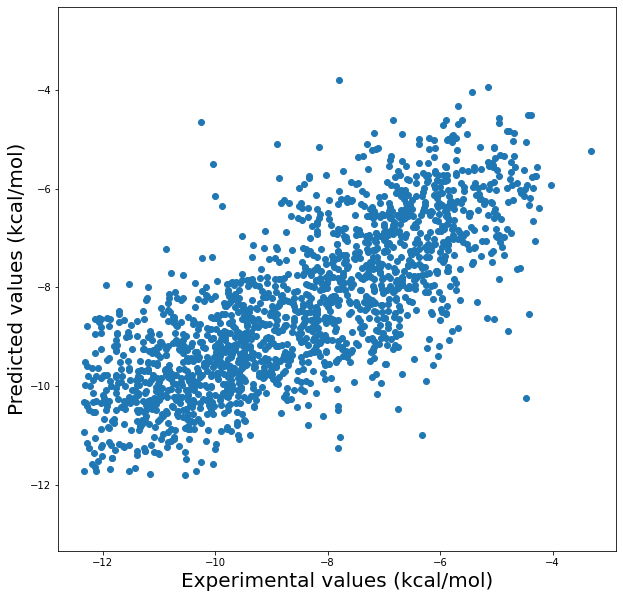

In [348]:
# Predict energy for test set
observed_pred = predict(model, likelihood, X_test_transformed)

print('R2   : %.3f' % pearsonr(y_test, observed_pred.mean.numpy())[0]**2)
print('RMSD : %.3f kcal/mol' % rmsd(y_test, observed_pred.mean.numpy()))

# Plot results
plot(y_test.numpy(), observed_pred.mean.numpy(), fig_filename='correlation_exp_pred_extended_z-scale_mhc-i_cleaned.png')

### Extended DPPS descriptors + RBF kernel

In [349]:
descriptors = pd.read_csv('extended_dpps.csv')

X_train_transformed = transform(X_train, descriptors)
X_test_transformed = transform(X_test, descriptors)

In [350]:
# Initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(X_train_transformed, y_train, likelihood)

# Train GP model
train(model, likelihood, X_train_transformed, y_train, training_iter=1000)

Iter 01/1000 - Loss: 28.666   lengthscale: 0.693   noise: 0.693
Iter 02/1000 - Loss: 26.233   lengthscale: 0.744   noise: 0.744
Iter 03/1000 - Loss: 24.062   lengthscale: 0.796   noise: 0.798
Iter 04/1000 - Loss: 22.125   lengthscale: 0.850   noise: 0.853
Iter 05/1000 - Loss: 20.399   lengthscale: 0.905   noise: 0.911
Iter 06/1000 - Loss: 18.861   lengthscale: 0.962   noise: 0.969
Iter 07/1000 - Loss: 17.491   lengthscale: 1.022   noise: 1.029
Iter 08/1000 - Loss: 16.270   lengthscale: 1.085   noise: 1.090
Iter 09/1000 - Loss: 15.180   lengthscale: 1.151   noise: 1.151
Iter 10/1000 - Loss: 14.207   lengthscale: 1.220   noise: 1.213
Iter 11/1000 - Loss: 13.336   lengthscale: 1.293   noise: 1.274
Iter 12/1000 - Loss: 12.555   lengthscale: 1.368   noise: 1.336
Iter 13/1000 - Loss: 11.854   lengthscale: 1.447   noise: 1.396
Iter 14/1000 - Loss: 11.224   lengthscale: 1.529   noise: 1.457
Iter 15/1000 - Loss: 10.655   lengthscale: 1.613   noise: 1.516
Iter 16/1000 - Loss: 10.140   lengthscal

Iter 130/1000 - Loss: 1.988   lengthscale: 12.901   noise: 2.913
Iter 131/1000 - Loss: 1.987   lengthscale: 12.928   noise: 2.911
Iter 132/1000 - Loss: 1.985   lengthscale: 12.955   noise: 2.908
Iter 133/1000 - Loss: 1.981   lengthscale: 12.982   noise: 2.904
Iter 134/1000 - Loss: 1.985   lengthscale: 13.009   noise: 2.901
Iter 135/1000 - Loss: 1.980   lengthscale: 13.036   noise: 2.898
Iter 136/1000 - Loss: 1.981   lengthscale: 13.062   noise: 2.895
Iter 137/1000 - Loss: 1.979   lengthscale: 13.088   noise: 2.892
Iter 138/1000 - Loss: 1.976   lengthscale: 13.114   noise: 2.889
Iter 139/1000 - Loss: 1.976   lengthscale: 13.140   noise: 2.886
Iter 140/1000 - Loss: 1.976   lengthscale: 13.166   noise: 2.883
Iter 141/1000 - Loss: 1.974   lengthscale: 13.191   noise: 2.880
Iter 142/1000 - Loss: 1.972   lengthscale: 13.217   noise: 2.876
Iter 143/1000 - Loss: 1.971   lengthscale: 13.242   noise: 2.873
Iter 144/1000 - Loss: 1.970   lengthscale: 13.267   noise: 2.870
Iter 145/1000 - Loss: 1.9

Iter 258/1000 - Loss: 1.861   lengthscale: 15.667   noise: 2.396
Iter 259/1000 - Loss: 1.861   lengthscale: 15.686   noise: 2.391
Iter 260/1000 - Loss: 1.859   lengthscale: 15.705   noise: 2.386
Iter 261/1000 - Loss: 1.860   lengthscale: 15.723   noise: 2.381
Iter 262/1000 - Loss: 1.857   lengthscale: 15.742   noise: 2.376
Iter 263/1000 - Loss: 1.858   lengthscale: 15.760   noise: 2.371
Iter 264/1000 - Loss: 1.859   lengthscale: 15.779   noise: 2.366
Iter 265/1000 - Loss: 1.856   lengthscale: 15.797   noise: 2.361
Iter 266/1000 - Loss: 1.857   lengthscale: 15.815   noise: 2.356
Iter 267/1000 - Loss: 1.856   lengthscale: 15.834   noise: 2.351
Iter 268/1000 - Loss: 1.851   lengthscale: 15.852   noise: 2.346
Iter 269/1000 - Loss: 1.851   lengthscale: 15.870   noise: 2.341
Iter 270/1000 - Loss: 1.852   lengthscale: 15.889   noise: 2.336
Iter 271/1000 - Loss: 1.853   lengthscale: 15.907   noise: 2.331
Iter 272/1000 - Loss: 1.849   lengthscale: 15.925   noise: 2.326
Iter 273/1000 - Loss: 1.8

Iter 386/1000 - Loss: 1.767   lengthscale: 17.814   noise: 1.714
Iter 387/1000 - Loss: 1.768   lengthscale: 17.829   noise: 1.709
Iter 388/1000 - Loss: 1.765   lengthscale: 17.843   noise: 1.703
Iter 389/1000 - Loss: 1.760   lengthscale: 17.858   noise: 1.698
Iter 390/1000 - Loss: 1.762   lengthscale: 17.873   noise: 1.693
Iter 391/1000 - Loss: 1.762   lengthscale: 17.888   noise: 1.688
Iter 392/1000 - Loss: 1.761   lengthscale: 17.902   noise: 1.682
Iter 393/1000 - Loss: 1.762   lengthscale: 17.917   noise: 1.677
Iter 394/1000 - Loss: 1.763   lengthscale: 17.932   noise: 1.672
Iter 395/1000 - Loss: 1.759   lengthscale: 17.946   noise: 1.666
Iter 396/1000 - Loss: 1.761   lengthscale: 17.961   noise: 1.661
Iter 397/1000 - Loss: 1.757   lengthscale: 17.975   noise: 1.656
Iter 398/1000 - Loss: 1.757   lengthscale: 17.990   noise: 1.651
Iter 399/1000 - Loss: 1.762   lengthscale: 18.004   noise: 1.645
Iter 400/1000 - Loss: 1.755   lengthscale: 18.019   noise: 1.640
Iter 401/1000 - Loss: 1.7

Iter 514/1000 - Loss: 1.709   lengthscale: 19.385   noise: 1.171
Iter 515/1000 - Loss: 1.711   lengthscale: 19.394   noise: 1.169
Iter 516/1000 - Loss: 1.713   lengthscale: 19.404   noise: 1.166
Iter 517/1000 - Loss: 1.711   lengthscale: 19.413   noise: 1.163
Iter 518/1000 - Loss: 1.712   lengthscale: 19.422   noise: 1.160
Iter 519/1000 - Loss: 1.711   lengthscale: 19.432   noise: 1.158
Iter 520/1000 - Loss: 1.708   lengthscale: 19.441   noise: 1.155
Iter 521/1000 - Loss: 1.709   lengthscale: 19.450   noise: 1.152
Iter 522/1000 - Loss: 1.710   lengthscale: 19.459   noise: 1.150
Iter 523/1000 - Loss: 1.710   lengthscale: 19.469   noise: 1.147
Iter 524/1000 - Loss: 1.707   lengthscale: 19.478   noise: 1.145
Iter 525/1000 - Loss: 1.708   lengthscale: 19.487   noise: 1.142
Iter 526/1000 - Loss: 1.713   lengthscale: 19.496   noise: 1.140
Iter 527/1000 - Loss: 1.713   lengthscale: 19.505   noise: 1.137
Iter 528/1000 - Loss: 1.708   lengthscale: 19.514   noise: 1.135
Iter 529/1000 - Loss: 1.7

Iter 642/1000 - Loss: 1.701   lengthscale: 20.261   noise: 0.985
Iter 643/1000 - Loss: 1.699   lengthscale: 20.266   noise: 0.984
Iter 644/1000 - Loss: 1.702   lengthscale: 20.271   noise: 0.984
Iter 645/1000 - Loss: 1.702   lengthscale: 20.276   noise: 0.983
Iter 646/1000 - Loss: 1.703   lengthscale: 20.281   noise: 0.983
Iter 647/1000 - Loss: 1.701   lengthscale: 20.285   noise: 0.982
Iter 648/1000 - Loss: 1.699   lengthscale: 20.290   noise: 0.982
Iter 649/1000 - Loss: 1.702   lengthscale: 20.295   noise: 0.982
Iter 650/1000 - Loss: 1.701   lengthscale: 20.299   noise: 0.981
Iter 651/1000 - Loss: 1.702   lengthscale: 20.304   noise: 0.981
Iter 652/1000 - Loss: 1.702   lengthscale: 20.309   noise: 0.980
Iter 653/1000 - Loss: 1.701   lengthscale: 20.313   noise: 0.980
Iter 654/1000 - Loss: 1.707   lengthscale: 20.318   noise: 0.979
Iter 655/1000 - Loss: 1.701   lengthscale: 20.323   noise: 0.979
Iter 656/1000 - Loss: 1.701   lengthscale: 20.327   noise: 0.979
Iter 657/1000 - Loss: 1.6

Iter 770/1000 - Loss: 1.700   lengthscale: 20.773   noise: 0.965
Iter 771/1000 - Loss: 1.701   lengthscale: 20.777   noise: 0.965
Iter 772/1000 - Loss: 1.701   lengthscale: 20.780   noise: 0.965
Iter 773/1000 - Loss: 1.695   lengthscale: 20.784   noise: 0.965
Iter 774/1000 - Loss: 1.700   lengthscale: 20.787   noise: 0.965
Iter 775/1000 - Loss: 1.697   lengthscale: 20.791   noise: 0.965
Iter 776/1000 - Loss: 1.698   lengthscale: 20.794   noise: 0.965
Iter 777/1000 - Loss: 1.696   lengthscale: 20.798   noise: 0.965
Iter 778/1000 - Loss: 1.699   lengthscale: 20.801   noise: 0.965
Iter 779/1000 - Loss: 1.696   lengthscale: 20.805   noise: 0.965
Iter 780/1000 - Loss: 1.695   lengthscale: 20.808   noise: 0.965
Iter 781/1000 - Loss: 1.700   lengthscale: 20.812   noise: 0.965
Iter 782/1000 - Loss: 1.697   lengthscale: 20.815   noise: 0.965
Iter 783/1000 - Loss: 1.699   lengthscale: 20.819   noise: 0.965
Iter 784/1000 - Loss: 1.702   lengthscale: 20.822   noise: 0.965
Iter 785/1000 - Loss: 1.6

Iter 898/1000 - Loss: 1.696   lengthscale: 21.215   noise: 0.971
Iter 899/1000 - Loss: 1.694   lengthscale: 21.218   noise: 0.971
Iter 900/1000 - Loss: 1.695   lengthscale: 21.222   noise: 0.971
Iter 901/1000 - Loss: 1.698   lengthscale: 21.225   noise: 0.971
Iter 902/1000 - Loss: 1.702   lengthscale: 21.228   noise: 0.971
Iter 903/1000 - Loss: 1.697   lengthscale: 21.232   noise: 0.971
Iter 904/1000 - Loss: 1.691   lengthscale: 21.235   noise: 0.971
Iter 905/1000 - Loss: 1.696   lengthscale: 21.239   noise: 0.971
Iter 906/1000 - Loss: 1.698   lengthscale: 21.242   noise: 0.971
Iter 907/1000 - Loss: 1.699   lengthscale: 21.246   noise: 0.971
Iter 908/1000 - Loss: 1.699   lengthscale: 21.249   noise: 0.971
Iter 909/1000 - Loss: 1.704   lengthscale: 21.253   noise: 0.971
Iter 910/1000 - Loss: 1.694   lengthscale: 21.256   noise: 0.971
Iter 911/1000 - Loss: 1.700   lengthscale: 21.260   noise: 0.971
Iter 912/1000 - Loss: 1.697   lengthscale: 21.263   noise: 0.971
Iter 913/1000 - Loss: 1.6

R2   : 0.610
RMSD : 1.261 kcal/mol


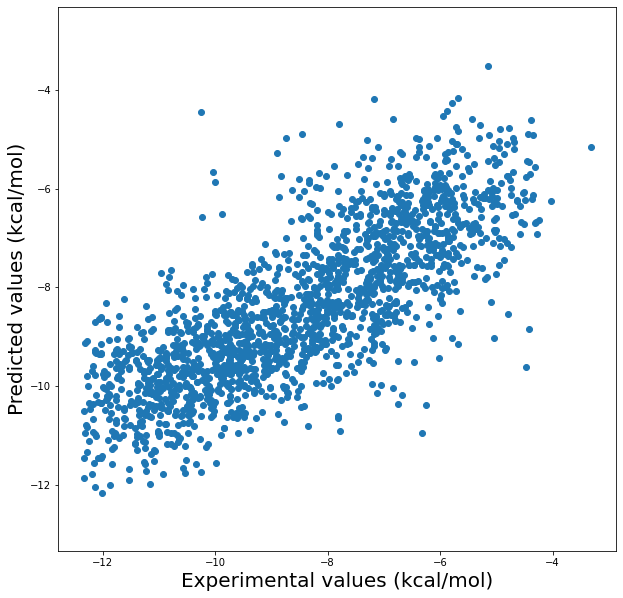

In [351]:
# Predict energy for test set
observed_pred = predict(model, likelihood, X_test_transformed)

print('R2   : %.3f' % pearsonr(y_test, observed_pred.mean.numpy())[0]**2)
print('RMSD : %.3f kcal/mol' % rmsd(y_test, observed_pred.mean.numpy()))

# Plot results
plot(y_test.numpy(), observed_pred.mean.numpy(), fig_filename='correlation_exp_pred_extended_dpps-scale_mhc-i_cleaned.png')

### ISA-ESI descriptors + RBF kernel

In [352]:
descriptors = pd.read_csv('isa-esi_scale.csv')
# Normalize ISA
descriptors['ISA'] = (descriptors['ISA'].max() - descriptors['ISA']) / (descriptors['ISA'].max() - descriptors['ISA'].min())

X_train_transformed = transform(X_train, descriptors)
X_test_transformed = transform(X_test, descriptors)

In [353]:
# Initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(X_train_transformed, y_train, likelihood)

# Train GP model
train(model, likelihood, X_train_transformed, y_train, training_iter=1000)

Iter 01/1000 - Loss: 4.878   lengthscale: 0.693   noise: 0.693
Iter 02/1000 - Loss: 3.993   lengthscale: 0.744   noise: 0.744
Iter 03/1000 - Loss: 3.410   lengthscale: 0.796   noise: 0.797
Iter 04/1000 - Loss: 3.020   lengthscale: 0.848   noise: 0.852
Iter 05/1000 - Loss: 2.755   lengthscale: 0.899   noise: 0.907
Iter 06/1000 - Loss: 2.571   lengthscale: 0.947   noise: 0.963
Iter 07/1000 - Loss: 2.439   lengthscale: 0.994   noise: 1.019
Iter 08/1000 - Loss: 2.341   lengthscale: 1.038   noise: 1.076
Iter 09/1000 - Loss: 2.265   lengthscale: 1.080   noise: 1.132
Iter 10/1000 - Loss: 2.210   lengthscale: 1.120   noise: 1.189
Iter 11/1000 - Loss: 2.165   lengthscale: 1.157   noise: 1.245
Iter 12/1000 - Loss: 2.127   lengthscale: 1.192   noise: 1.300
Iter 13/1000 - Loss: 2.100   lengthscale: 1.224   noise: 1.355
Iter 14/1000 - Loss: 2.076   lengthscale: 1.255   noise: 1.409
Iter 15/1000 - Loss: 2.053   lengthscale: 1.283   noise: 1.461
Iter 16/1000 - Loss: 2.038   lengthscale: 1.310   noise

Iter 131/1000 - Loss: 1.912   lengthscale: 1.813   noise: 2.311
Iter 132/1000 - Loss: 1.913   lengthscale: 1.814   noise: 2.311
Iter 133/1000 - Loss: 1.915   lengthscale: 1.815   noise: 2.311
Iter 134/1000 - Loss: 1.911   lengthscale: 1.817   noise: 2.310
Iter 135/1000 - Loss: 1.913   lengthscale: 1.818   noise: 2.310
Iter 136/1000 - Loss: 1.913   lengthscale: 1.819   noise: 2.310
Iter 137/1000 - Loss: 1.914   lengthscale: 1.820   noise: 2.310
Iter 138/1000 - Loss: 1.913   lengthscale: 1.822   noise: 2.310
Iter 139/1000 - Loss: 1.913   lengthscale: 1.823   noise: 2.309
Iter 140/1000 - Loss: 1.911   lengthscale: 1.824   noise: 2.309
Iter 141/1000 - Loss: 1.909   lengthscale: 1.825   noise: 2.309
Iter 142/1000 - Loss: 1.913   lengthscale: 1.826   noise: 2.310
Iter 143/1000 - Loss: 1.912   lengthscale: 1.828   noise: 2.310
Iter 144/1000 - Loss: 1.912   lengthscale: 1.829   noise: 2.310
Iter 145/1000 - Loss: 1.912   lengthscale: 1.830   noise: 2.310
Iter 146/1000 - Loss: 1.911   lengthscal

Iter 261/1000 - Loss: 1.902   lengthscale: 1.902   noise: 2.291
Iter 262/1000 - Loss: 1.902   lengthscale: 1.902   noise: 2.291
Iter 263/1000 - Loss: 1.900   lengthscale: 1.903   noise: 2.291
Iter 264/1000 - Loss: 1.902   lengthscale: 1.903   noise: 2.292
Iter 265/1000 - Loss: 1.902   lengthscale: 1.903   noise: 2.293
Iter 266/1000 - Loss: 1.901   lengthscale: 1.903   noise: 2.293
Iter 267/1000 - Loss: 1.901   lengthscale: 1.903   noise: 2.294
Iter 268/1000 - Loss: 1.902   lengthscale: 1.903   noise: 2.294
Iter 269/1000 - Loss: 1.902   lengthscale: 1.903   noise: 2.294
Iter 270/1000 - Loss: 1.902   lengthscale: 1.903   noise: 2.293
Iter 271/1000 - Loss: 1.902   lengthscale: 1.904   noise: 2.293
Iter 272/1000 - Loss: 1.900   lengthscale: 1.904   noise: 2.292
Iter 273/1000 - Loss: 1.900   lengthscale: 1.904   noise: 2.292
Iter 274/1000 - Loss: 1.902   lengthscale: 1.904   noise: 2.291
Iter 275/1000 - Loss: 1.902   lengthscale: 1.904   noise: 2.290
Iter 276/1000 - Loss: 1.900   lengthscal

Iter 391/1000 - Loss: 1.898   lengthscale: 1.887   noise: 2.256
Iter 392/1000 - Loss: 1.896   lengthscale: 1.887   noise: 2.256
Iter 393/1000 - Loss: 1.896   lengthscale: 1.886   noise: 2.256
Iter 394/1000 - Loss: 1.895   lengthscale: 1.886   noise: 2.256
Iter 395/1000 - Loss: 1.897   lengthscale: 1.885   noise: 2.255
Iter 396/1000 - Loss: 1.894   lengthscale: 1.885   noise: 2.254
Iter 397/1000 - Loss: 1.898   lengthscale: 1.885   noise: 2.254
Iter 398/1000 - Loss: 1.895   lengthscale: 1.885   noise: 2.253
Iter 399/1000 - Loss: 1.897   lengthscale: 1.884   noise: 2.253
Iter 400/1000 - Loss: 1.898   lengthscale: 1.884   noise: 2.253
Iter 401/1000 - Loss: 1.898   lengthscale: 1.884   noise: 2.252
Iter 402/1000 - Loss: 1.897   lengthscale: 1.883   noise: 2.252
Iter 403/1000 - Loss: 1.896   lengthscale: 1.883   noise: 2.252
Iter 404/1000 - Loss: 1.895   lengthscale: 1.883   noise: 2.252
Iter 405/1000 - Loss: 1.895   lengthscale: 1.882   noise: 2.252
Iter 406/1000 - Loss: 1.897   lengthscal

Iter 521/1000 - Loss: 1.895   lengthscale: 1.826   noise: 2.221
Iter 522/1000 - Loss: 1.893   lengthscale: 1.825   noise: 2.221
Iter 523/1000 - Loss: 1.895   lengthscale: 1.825   noise: 2.221
Iter 524/1000 - Loss: 1.892   lengthscale: 1.824   noise: 2.221
Iter 525/1000 - Loss: 1.893   lengthscale: 1.824   noise: 2.221
Iter 526/1000 - Loss: 1.892   lengthscale: 1.823   noise: 2.221
Iter 527/1000 - Loss: 1.892   lengthscale: 1.823   noise: 2.221
Iter 528/1000 - Loss: 1.895   lengthscale: 1.822   noise: 2.220
Iter 529/1000 - Loss: 1.893   lengthscale: 1.822   noise: 2.220
Iter 530/1000 - Loss: 1.894   lengthscale: 1.821   noise: 2.220
Iter 531/1000 - Loss: 1.894   lengthscale: 1.821   noise: 2.220
Iter 532/1000 - Loss: 1.894   lengthscale: 1.820   noise: 2.219
Iter 533/1000 - Loss: 1.895   lengthscale: 1.820   noise: 2.219
Iter 534/1000 - Loss: 1.892   lengthscale: 1.819   noise: 2.219
Iter 535/1000 - Loss: 1.894   lengthscale: 1.819   noise: 2.218
Iter 536/1000 - Loss: 1.894   lengthscal

Iter 651/1000 - Loss: 1.892   lengthscale: 1.771   noise: 2.187
Iter 652/1000 - Loss: 1.890   lengthscale: 1.771   noise: 2.187
Iter 653/1000 - Loss: 1.890   lengthscale: 1.770   noise: 2.187
Iter 654/1000 - Loss: 1.890   lengthscale: 1.770   noise: 2.187
Iter 655/1000 - Loss: 1.894   lengthscale: 1.769   noise: 2.187
Iter 656/1000 - Loss: 1.892   lengthscale: 1.769   noise: 2.187
Iter 657/1000 - Loss: 1.892   lengthscale: 1.769   noise: 2.187
Iter 658/1000 - Loss: 1.889   lengthscale: 1.768   noise: 2.187
Iter 659/1000 - Loss: 1.892   lengthscale: 1.768   noise: 2.187
Iter 660/1000 - Loss: 1.891   lengthscale: 1.768   noise: 2.186
Iter 661/1000 - Loss: 1.892   lengthscale: 1.768   noise: 2.186
Iter 662/1000 - Loss: 1.890   lengthscale: 1.767   noise: 2.186
Iter 663/1000 - Loss: 1.887   lengthscale: 1.767   noise: 2.185
Iter 664/1000 - Loss: 1.890   lengthscale: 1.766   noise: 2.184
Iter 665/1000 - Loss: 1.890   lengthscale: 1.766   noise: 2.183
Iter 666/1000 - Loss: 1.893   lengthscal

Iter 781/1000 - Loss: 1.889   lengthscale: 1.741   noise: 2.163
Iter 782/1000 - Loss: 1.891   lengthscale: 1.741   noise: 2.164
Iter 783/1000 - Loss: 1.892   lengthscale: 1.740   noise: 2.164
Iter 784/1000 - Loss: 1.888   lengthscale: 1.740   noise: 2.164
Iter 785/1000 - Loss: 1.891   lengthscale: 1.740   noise: 2.164
Iter 786/1000 - Loss: 1.891   lengthscale: 1.740   noise: 2.164
Iter 787/1000 - Loss: 1.891   lengthscale: 1.740   noise: 2.164
Iter 788/1000 - Loss: 1.891   lengthscale: 1.739   noise: 2.164
Iter 789/1000 - Loss: 1.894   lengthscale: 1.739   noise: 2.165
Iter 790/1000 - Loss: 1.890   lengthscale: 1.739   noise: 2.165
Iter 791/1000 - Loss: 1.892   lengthscale: 1.739   noise: 2.165
Iter 792/1000 - Loss: 1.891   lengthscale: 1.739   noise: 2.166
Iter 793/1000 - Loss: 1.888   lengthscale: 1.739   noise: 2.166
Iter 794/1000 - Loss: 1.890   lengthscale: 1.738   noise: 2.167
Iter 795/1000 - Loss: 1.891   lengthscale: 1.738   noise: 2.167
Iter 796/1000 - Loss: 1.891   lengthscal

Iter 911/1000 - Loss: 1.890   lengthscale: 1.731   noise: 2.157
Iter 912/1000 - Loss: 1.888   lengthscale: 1.731   noise: 2.157
Iter 913/1000 - Loss: 1.889   lengthscale: 1.731   noise: 2.158
Iter 914/1000 - Loss: 1.891   lengthscale: 1.731   noise: 2.158
Iter 915/1000 - Loss: 1.889   lengthscale: 1.731   noise: 2.158
Iter 916/1000 - Loss: 1.889   lengthscale: 1.731   noise: 2.158
Iter 917/1000 - Loss: 1.889   lengthscale: 1.731   noise: 2.158
Iter 918/1000 - Loss: 1.890   lengthscale: 1.731   noise: 2.159
Iter 919/1000 - Loss: 1.888   lengthscale: 1.731   noise: 2.159
Iter 920/1000 - Loss: 1.892   lengthscale: 1.731   noise: 2.159
Iter 921/1000 - Loss: 1.888   lengthscale: 1.731   noise: 2.159
Iter 922/1000 - Loss: 1.893   lengthscale: 1.731   noise: 2.160
Iter 923/1000 - Loss: 1.889   lengthscale: 1.731   noise: 2.160
Iter 924/1000 - Loss: 1.891   lengthscale: 1.731   noise: 2.161
Iter 925/1000 - Loss: 1.889   lengthscale: 1.730   noise: 2.162
Iter 926/1000 - Loss: 1.890   lengthscal

R2   : 0.416
RMSD : 1.538 kcal/mol


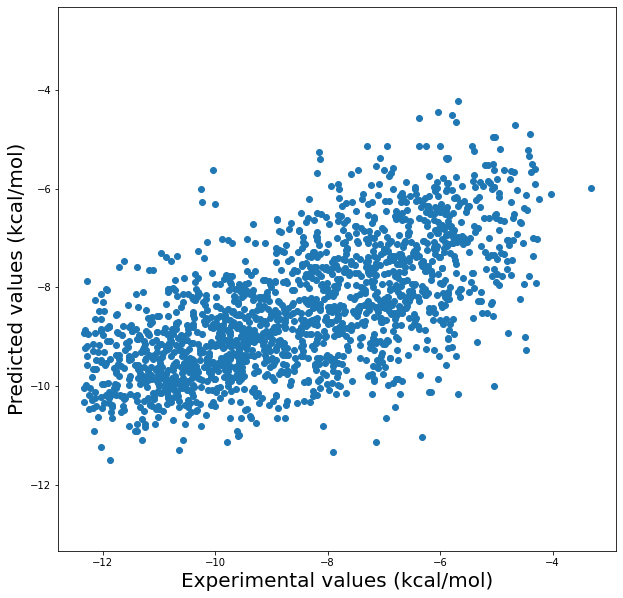

In [354]:
# Predict energy for test set
observed_pred = predict(model, likelihood, X_test_transformed)

print('R2   : %.3f' % pearsonr(y_test, observed_pred.mean.numpy())[0]**2)
print('RMSD : %.3f kcal/mol' % rmsd(y_test, observed_pred.mean.numpy()))

# Plot results
plot(y_test.numpy(), observed_pred.mean.numpy(), fig_filename='correlation_exp_pred_extended_isa-esi-scale_mhc-i_cleaned.png')

### PCA descriptors + RBF kernel

In [355]:
descriptors = pd.read_csv('pca.csv')

X_train_transformed = transform(X_train, descriptors)
X_test_transformed = transform(X_test, descriptors)

In [356]:
# Initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(X_train_transformed, y_train, likelihood)

# Train GP model
train(model, likelihood, X_train_transformed, y_train, training_iter=1000)

Iter 01/1000 - Loss: 3.288   lengthscale: 0.693   noise: 0.693
Iter 02/1000 - Loss: 2.732   lengthscale: 0.744   noise: 0.744
Iter 03/1000 - Loss: 2.406   lengthscale: 0.796   noise: 0.797
Iter 04/1000 - Loss: 2.207   lengthscale: 0.846   noise: 0.849
Iter 05/1000 - Loss: 2.078   lengthscale: 0.894   noise: 0.902
Iter 06/1000 - Loss: 1.992   lengthscale: 0.940   noise: 0.953
Iter 07/1000 - Loss: 1.932   lengthscale: 0.983   noise: 1.004
Iter 08/1000 - Loss: 1.896   lengthscale: 1.024   noise: 1.054
Iter 09/1000 - Loss: 1.861   lengthscale: 1.062   noise: 1.103
Iter 10/1000 - Loss: 1.841   lengthscale: 1.098   noise: 1.150
Iter 11/1000 - Loss: 1.822   lengthscale: 1.131   noise: 1.194
Iter 12/1000 - Loss: 1.812   lengthscale: 1.163   noise: 1.237
Iter 13/1000 - Loss: 1.800   lengthscale: 1.192   noise: 1.278
Iter 14/1000 - Loss: 1.793   lengthscale: 1.219   noise: 1.316
Iter 15/1000 - Loss: 1.784   lengthscale: 1.244   noise: 1.352
Iter 16/1000 - Loss: 1.780   lengthscale: 1.267   noise

Iter 131/1000 - Loss: 1.723   lengthscale: 1.427   noise: 1.226
Iter 132/1000 - Loss: 1.723   lengthscale: 1.426   noise: 1.223
Iter 133/1000 - Loss: 1.726   lengthscale: 1.424   noise: 1.220
Iter 134/1000 - Loss: 1.729   lengthscale: 1.423   noise: 1.217
Iter 135/1000 - Loss: 1.727   lengthscale: 1.421   noise: 1.214
Iter 136/1000 - Loss: 1.727   lengthscale: 1.420   noise: 1.212
Iter 137/1000 - Loss: 1.724   lengthscale: 1.418   noise: 1.210
Iter 138/1000 - Loss: 1.722   lengthscale: 1.417   noise: 1.208
Iter 139/1000 - Loss: 1.722   lengthscale: 1.416   noise: 1.206
Iter 140/1000 - Loss: 1.720   lengthscale: 1.414   noise: 1.204
Iter 141/1000 - Loss: 1.724   lengthscale: 1.413   noise: 1.202
Iter 142/1000 - Loss: 1.723   lengthscale: 1.411   noise: 1.200
Iter 143/1000 - Loss: 1.722   lengthscale: 1.410   noise: 1.198
Iter 144/1000 - Loss: 1.724   lengthscale: 1.409   noise: 1.196
Iter 145/1000 - Loss: 1.723   lengthscale: 1.407   noise: 1.194
Iter 146/1000 - Loss: 1.719   lengthscal

Iter 261/1000 - Loss: 1.709   lengthscale: 1.289   noise: 0.983
Iter 262/1000 - Loss: 1.710   lengthscale: 1.288   noise: 0.982
Iter 263/1000 - Loss: 1.710   lengthscale: 1.287   noise: 0.981
Iter 264/1000 - Loss: 1.707   lengthscale: 1.286   noise: 0.980
Iter 265/1000 - Loss: 1.714   lengthscale: 1.285   noise: 0.978
Iter 266/1000 - Loss: 1.716   lengthscale: 1.284   noise: 0.977
Iter 267/1000 - Loss: 1.710   lengthscale: 1.283   noise: 0.976
Iter 268/1000 - Loss: 1.712   lengthscale: 1.282   noise: 0.975
Iter 269/1000 - Loss: 1.711   lengthscale: 1.281   noise: 0.975
Iter 270/1000 - Loss: 1.709   lengthscale: 1.280   noise: 0.975
Iter 271/1000 - Loss: 1.708   lengthscale: 1.279   noise: 0.974
Iter 272/1000 - Loss: 1.709   lengthscale: 1.278   noise: 0.973
Iter 273/1000 - Loss: 1.713   lengthscale: 1.277   noise: 0.971
Iter 274/1000 - Loss: 1.707   lengthscale: 1.276   noise: 0.970
Iter 275/1000 - Loss: 1.710   lengthscale: 1.276   noise: 0.968
Iter 276/1000 - Loss: 1.710   lengthscal

Iter 391/1000 - Loss: 1.705   lengthscale: 1.198   noise: 0.830
Iter 392/1000 - Loss: 1.708   lengthscale: 1.197   noise: 0.829
Iter 393/1000 - Loss: 1.706   lengthscale: 1.197   noise: 0.829
Iter 394/1000 - Loss: 1.706   lengthscale: 1.196   noise: 0.829
Iter 395/1000 - Loss: 1.706   lengthscale: 1.195   noise: 0.829
Iter 396/1000 - Loss: 1.703   lengthscale: 1.194   noise: 0.828
Iter 397/1000 - Loss: 1.707   lengthscale: 1.193   noise: 0.828
Iter 398/1000 - Loss: 1.712   lengthscale: 1.193   noise: 0.827
Iter 399/1000 - Loss: 1.705   lengthscale: 1.192   noise: 0.827
Iter 400/1000 - Loss: 1.699   lengthscale: 1.191   noise: 0.826
Iter 401/1000 - Loss: 1.701   lengthscale: 1.191   noise: 0.825
Iter 402/1000 - Loss: 1.704   lengthscale: 1.190   noise: 0.824
Iter 403/1000 - Loss: 1.707   lengthscale: 1.189   noise: 0.823
Iter 404/1000 - Loss: 1.707   lengthscale: 1.189   noise: 0.822
Iter 405/1000 - Loss: 1.705   lengthscale: 1.188   noise: 0.820
Iter 406/1000 - Loss: 1.702   lengthscal

Iter 521/1000 - Loss: 1.705   lengthscale: 1.137   noise: 0.762
Iter 522/1000 - Loss: 1.705   lengthscale: 1.136   noise: 0.762
Iter 523/1000 - Loss: 1.705   lengthscale: 1.136   noise: 0.762
Iter 524/1000 - Loss: 1.705   lengthscale: 1.136   noise: 0.762
Iter 525/1000 - Loss: 1.707   lengthscale: 1.136   noise: 0.763
Iter 526/1000 - Loss: 1.708   lengthscale: 1.136   noise: 0.762
Iter 527/1000 - Loss: 1.705   lengthscale: 1.136   noise: 0.761
Iter 528/1000 - Loss: 1.706   lengthscale: 1.135   noise: 0.761
Iter 529/1000 - Loss: 1.704   lengthscale: 1.135   noise: 0.761
Iter 530/1000 - Loss: 1.707   lengthscale: 1.135   noise: 0.761
Iter 531/1000 - Loss: 1.706   lengthscale: 1.135   noise: 0.760
Iter 532/1000 - Loss: 1.707   lengthscale: 1.134   noise: 0.760
Iter 533/1000 - Loss: 1.707   lengthscale: 1.134   noise: 0.760
Iter 534/1000 - Loss: 1.705   lengthscale: 1.134   noise: 0.760
Iter 535/1000 - Loss: 1.705   lengthscale: 1.134   noise: 0.760
Iter 536/1000 - Loss: 1.708   lengthscal

Iter 651/1000 - Loss: 1.706   lengthscale: 1.110   noise: 0.767
Iter 652/1000 - Loss: 1.706   lengthscale: 1.109   noise: 0.769
Iter 653/1000 - Loss: 1.705   lengthscale: 1.109   noise: 0.770
Iter 654/1000 - Loss: 1.709   lengthscale: 1.108   noise: 0.770
Iter 655/1000 - Loss: 1.709   lengthscale: 1.108   noise: 0.770
Iter 656/1000 - Loss: 1.705   lengthscale: 1.108   noise: 0.769
Iter 657/1000 - Loss: 1.703   lengthscale: 1.108   noise: 0.767
Iter 658/1000 - Loss: 1.707   lengthscale: 1.108   noise: 0.764
Iter 659/1000 - Loss: 1.709   lengthscale: 1.108   noise: 0.762
Iter 660/1000 - Loss: 1.706   lengthscale: 1.109   noise: 0.760
Iter 661/1000 - Loss: 1.705   lengthscale: 1.109   noise: 0.758
Iter 662/1000 - Loss: 1.707   lengthscale: 1.109   noise: 0.757
Iter 663/1000 - Loss: 1.708   lengthscale: 1.109   noise: 0.757
Iter 664/1000 - Loss: 1.702   lengthscale: 1.108   noise: 0.758
Iter 665/1000 - Loss: 1.704   lengthscale: 1.108   noise: 0.758
Iter 666/1000 - Loss: 1.707   lengthscal

Iter 781/1000 - Loss: 1.703   lengthscale: 1.098   noise: 0.772
Iter 782/1000 - Loss: 1.707   lengthscale: 1.098   noise: 0.769
Iter 783/1000 - Loss: 1.705   lengthscale: 1.098   noise: 0.766
Iter 784/1000 - Loss: 1.708   lengthscale: 1.098   noise: 0.765
Iter 785/1000 - Loss: 1.706   lengthscale: 1.098   noise: 0.765
Iter 786/1000 - Loss: 1.706   lengthscale: 1.098   noise: 0.764
Iter 787/1000 - Loss: 1.710   lengthscale: 1.097   noise: 0.764
Iter 788/1000 - Loss: 1.708   lengthscale: 1.097   noise: 0.764
Iter 789/1000 - Loss: 1.704   lengthscale: 1.096   noise: 0.765
Iter 790/1000 - Loss: 1.709   lengthscale: 1.096   noise: 0.765
Iter 791/1000 - Loss: 1.706   lengthscale: 1.095   noise: 0.767
Iter 792/1000 - Loss: 1.700   lengthscale: 1.094   noise: 0.768
Iter 793/1000 - Loss: 1.706   lengthscale: 1.094   noise: 0.770
Iter 794/1000 - Loss: 1.705   lengthscale: 1.093   noise: 0.772
Iter 795/1000 - Loss: 1.703   lengthscale: 1.092   noise: 0.773
Iter 796/1000 - Loss: 1.699   lengthscal

Iter 911/1000 - Loss: 1.708   lengthscale: 1.094   noise: 0.776
Iter 912/1000 - Loss: 1.703   lengthscale: 1.094   noise: 0.777
Iter 913/1000 - Loss: 1.707   lengthscale: 1.094   noise: 0.777
Iter 914/1000 - Loss: 1.705   lengthscale: 1.094   noise: 0.777
Iter 915/1000 - Loss: 1.699   lengthscale: 1.094   noise: 0.777
Iter 916/1000 - Loss: 1.704   lengthscale: 1.094   noise: 0.776
Iter 917/1000 - Loss: 1.708   lengthscale: 1.094   noise: 0.774
Iter 918/1000 - Loss: 1.702   lengthscale: 1.094   noise: 0.773
Iter 919/1000 - Loss: 1.708   lengthscale: 1.094   noise: 0.772
Iter 920/1000 - Loss: 1.704   lengthscale: 1.094   noise: 0.771
Iter 921/1000 - Loss: 1.706   lengthscale: 1.094   noise: 0.770
Iter 922/1000 - Loss: 1.710   lengthscale: 1.093   noise: 0.771
Iter 923/1000 - Loss: 1.708   lengthscale: 1.093   noise: 0.771
Iter 924/1000 - Loss: 1.707   lengthscale: 1.093   noise: 0.770
Iter 925/1000 - Loss: 1.707   lengthscale: 1.093   noise: 0.770
Iter 926/1000 - Loss: 1.706   lengthscal

R2   : 0.609
RMSD : 1.259 kcal/mol


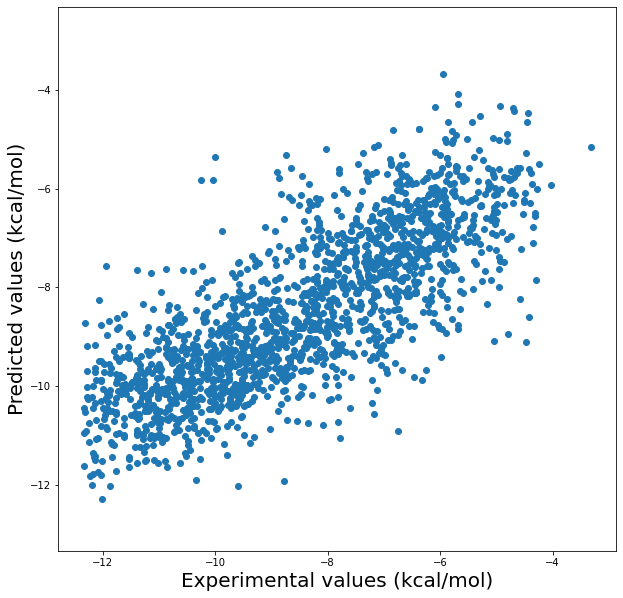

In [357]:
# Predict energy for test set
observed_pred = predict(model, likelihood, X_test_transformed)

print('R2   : %.3f' % pearsonr(y_test, observed_pred.mean.numpy())[0]**2)
print('RMSD : %.3f kcal/mol' % rmsd(y_test, observed_pred.mean.numpy()))

# Plot results
plot(y_test.numpy(), observed_pred.mean.numpy(), fig_filename='correlation_exp_pred_extended_pca-scale_mhc-i_cleaned.png')

## Training

In [101]:
def fingerprint(sequences, radius=10, nBits=4096):
    GMFABV = AllChem.GetMorganFingerprintAsBitVect
    fps = [np.array(GMFABV(Chem.rdmolfiles.MolFromFASTA(s), useChirality=True, useFeatures=True, radius=radius, nBits=nBits)) for s in sequences]
    return torch.from_numpy(np.array(fps)).float()

In [102]:
X_train_fps = fingerprint(X_train, radius=10)
X_test_fps = fingerprint(X_test, radius=10)

### MorganFingerprint + Cosine similarity kernel

In [103]:
class CosineSimilarityKernel(gpytorch.kernels.Kernel):
    # the sequence kernel is stationary
    is_stationary = True     

    # this is the kernel function
    def forward(self, x1, x2, **params):
        # Source: https://stackoverflow.com/questions/50411191/how-to-compute-the-cosine-similarity-in-pytorch-for-all-rows-in-a-matrix-with-re
        eps=1e-8
        
        # Normalize the rows, before computing their dot products via transposition
        x1_n = x1.norm(dim=1)[:, None]
        x2_n = x2.norm(dim=1)[:, None]
        x1_norm = x1 / torch.max(x1_n, eps * torch.ones_like(x1_n))
        x2_norm = x2 / torch.max(x2_n, eps * torch.ones_like(x2_n))
        sim_mt = torch.mm(x1_norm, x2_norm.transpose(0, 1))
        return sim_mt

    
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = CosineSimilarityKernel()

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    

# Wrap training, prediction and plotting from the ExactGP-Tutorial into a function,
# so that we do not have to repeat the code later on
def train(model, likelihood, train_x, train_y, training_iter=100):
    # Find optimal model hyperparameters
    model.train()
    likelihood.train()

    # Use the adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    for i in range(training_iter):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(train_x)
        # Calc loss and backprop gradients
        loss = -mll(output, train_y)
        loss.backward()
        
        print('Iter %04d/%d - Loss: %.3f   noise: %.3f' % (
            i + 1, training_iter, loss.item(),
            model.likelihood.noise.item()
        ))
        
        optimizer.step()

In [104]:
# Initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(X_train_fps, y_train, likelihood)

# Train GP model
train(model, likelihood, X_train_fps, y_train, training_iter=1000)

Iter 0001/1000 - Loss: 2.019   noise: 0.693
Iter 0002/1000 - Loss: 1.998   noise: 0.744
Iter 0003/1000 - Loss: 1.977   noise: 0.798
Iter 0004/1000 - Loss: 1.953   noise: 0.853
Iter 0005/1000 - Loss: 1.939   noise: 0.910
Iter 0006/1000 - Loss: 1.920   noise: 0.969
Iter 0007/1000 - Loss: 1.909   noise: 1.028
Iter 0008/1000 - Loss: 1.902   noise: 1.087
Iter 0009/1000 - Loss: 1.891   noise: 1.146
Iter 0010/1000 - Loss: 1.886   noise: 1.205
Iter 0011/1000 - Loss: 1.879   noise: 1.262
Iter 0012/1000 - Loss: 1.875   noise: 1.318
Iter 0013/1000 - Loss: 1.874   noise: 1.373
Iter 0014/1000 - Loss: 1.871   noise: 1.425
Iter 0015/1000 - Loss: 1.867   noise: 1.475
Iter 0016/1000 - Loss: 1.864   noise: 1.522
Iter 0017/1000 - Loss: 1.864   noise: 1.566
Iter 0018/1000 - Loss: 1.864   noise: 1.607
Iter 0019/1000 - Loss: 1.865   noise: 1.645
Iter 0020/1000 - Loss: 1.863   noise: 1.680
Iter 0021/1000 - Loss: 1.862   noise: 1.712
Iter 0022/1000 - Loss: 1.861   noise: 1.741
Iter 0023/1000 - Loss: 1.860   n

Iter 0188/1000 - Loss: 1.849   noise: 1.659
Iter 0189/1000 - Loss: 1.851   noise: 1.660
Iter 0190/1000 - Loss: 1.851   noise: 1.660
Iter 0191/1000 - Loss: 1.848   noise: 1.660
Iter 0192/1000 - Loss: 1.847   noise: 1.660
Iter 0193/1000 - Loss: 1.847   noise: 1.659
Iter 0194/1000 - Loss: 1.846   noise: 1.659
Iter 0195/1000 - Loss: 1.845   noise: 1.658
Iter 0196/1000 - Loss: 1.848   noise: 1.656
Iter 0197/1000 - Loss: 1.848   noise: 1.656
Iter 0198/1000 - Loss: 1.846   noise: 1.655
Iter 0199/1000 - Loss: 1.848   noise: 1.654
Iter 0200/1000 - Loss: 1.848   noise: 1.653
Iter 0201/1000 - Loss: 1.848   noise: 1.652
Iter 0202/1000 - Loss: 1.847   noise: 1.652
Iter 0203/1000 - Loss: 1.847   noise: 1.651
Iter 0204/1000 - Loss: 1.848   noise: 1.650
Iter 0205/1000 - Loss: 1.848   noise: 1.649
Iter 0206/1000 - Loss: 1.848   noise: 1.648
Iter 0207/1000 - Loss: 1.848   noise: 1.647
Iter 0208/1000 - Loss: 1.849   noise: 1.647
Iter 0209/1000 - Loss: 1.848   noise: 1.647
Iter 0210/1000 - Loss: 1.848   n

Iter 0375/1000 - Loss: 1.848   noise: 1.664
Iter 0376/1000 - Loss: 1.849   noise: 1.663
Iter 0377/1000 - Loss: 1.848   noise: 1.662
Iter 0378/1000 - Loss: 1.848   noise: 1.661
Iter 0379/1000 - Loss: 1.847   noise: 1.659
Iter 0380/1000 - Loss: 1.849   noise: 1.657
Iter 0381/1000 - Loss: 1.846   noise: 1.656
Iter 0382/1000 - Loss: 1.850   noise: 1.654
Iter 0383/1000 - Loss: 1.848   noise: 1.653
Iter 0384/1000 - Loss: 1.847   noise: 1.653
Iter 0385/1000 - Loss: 1.850   noise: 1.654
Iter 0386/1000 - Loss: 1.849   noise: 1.655
Iter 0387/1000 - Loss: 1.847   noise: 1.657
Iter 0388/1000 - Loss: 1.848   noise: 1.658
Iter 0389/1000 - Loss: 1.847   noise: 1.657
Iter 0390/1000 - Loss: 1.846   noise: 1.657
Iter 0391/1000 - Loss: 1.847   noise: 1.656
Iter 0392/1000 - Loss: 1.847   noise: 1.656
Iter 0393/1000 - Loss: 1.847   noise: 1.655
Iter 0394/1000 - Loss: 1.847   noise: 1.655
Iter 0395/1000 - Loss: 1.847   noise: 1.654
Iter 0396/1000 - Loss: 1.847   noise: 1.654
Iter 0397/1000 - Loss: 1.849   n

Iter 0562/1000 - Loss: 1.848   noise: 1.658
Iter 0563/1000 - Loss: 1.848   noise: 1.660
Iter 0564/1000 - Loss: 1.847   noise: 1.662
Iter 0565/1000 - Loss: 1.847   noise: 1.662
Iter 0566/1000 - Loss: 1.853   noise: 1.663
Iter 0567/1000 - Loss: 1.849   noise: 1.664
Iter 0568/1000 - Loss: 1.848   noise: 1.664
Iter 0569/1000 - Loss: 1.849   noise: 1.663
Iter 0570/1000 - Loss: 1.848   noise: 1.662
Iter 0571/1000 - Loss: 1.849   noise: 1.660
Iter 0572/1000 - Loss: 1.849   noise: 1.658
Iter 0573/1000 - Loss: 1.848   noise: 1.657
Iter 0574/1000 - Loss: 1.847   noise: 1.657
Iter 0575/1000 - Loss: 1.849   noise: 1.655
Iter 0576/1000 - Loss: 1.848   noise: 1.654
Iter 0577/1000 - Loss: 1.847   noise: 1.653
Iter 0578/1000 - Loss: 1.848   noise: 1.652
Iter 0579/1000 - Loss: 1.846   noise: 1.652
Iter 0580/1000 - Loss: 1.849   noise: 1.651
Iter 0581/1000 - Loss: 1.848   noise: 1.651
Iter 0582/1000 - Loss: 1.848   noise: 1.649
Iter 0583/1000 - Loss: 1.848   noise: 1.649
Iter 0584/1000 - Loss: 1.849   n

Iter 0749/1000 - Loss: 1.849   noise: 1.668
Iter 0750/1000 - Loss: 1.849   noise: 1.669
Iter 0751/1000 - Loss: 1.848   noise: 1.669
Iter 0752/1000 - Loss: 1.846   noise: 1.668
Iter 0753/1000 - Loss: 1.850   noise: 1.667
Iter 0754/1000 - Loss: 1.849   noise: 1.666
Iter 0755/1000 - Loss: 1.850   noise: 1.664
Iter 0756/1000 - Loss: 1.849   noise: 1.663
Iter 0757/1000 - Loss: 1.847   noise: 1.661
Iter 0758/1000 - Loss: 1.847   noise: 1.661
Iter 0759/1000 - Loss: 1.849   noise: 1.661
Iter 0760/1000 - Loss: 1.847   noise: 1.662
Iter 0761/1000 - Loss: 1.847   noise: 1.662
Iter 0762/1000 - Loss: 1.849   noise: 1.663
Iter 0763/1000 - Loss: 1.848   noise: 1.665
Iter 0764/1000 - Loss: 1.847   noise: 1.665
Iter 0765/1000 - Loss: 1.846   noise: 1.665
Iter 0766/1000 - Loss: 1.847   noise: 1.665
Iter 0767/1000 - Loss: 1.850   noise: 1.664
Iter 0768/1000 - Loss: 1.849   noise: 1.665
Iter 0769/1000 - Loss: 1.850   noise: 1.664
Iter 0770/1000 - Loss: 1.849   noise: 1.663
Iter 0771/1000 - Loss: 1.849   n

Iter 0936/1000 - Loss: 1.848   noise: 1.664
Iter 0937/1000 - Loss: 1.849   noise: 1.662
Iter 0938/1000 - Loss: 1.848   noise: 1.659
Iter 0939/1000 - Loss: 1.848   noise: 1.655
Iter 0940/1000 - Loss: 1.847   noise: 1.653
Iter 0941/1000 - Loss: 1.848   noise: 1.649
Iter 0942/1000 - Loss: 1.845   noise: 1.647
Iter 0943/1000 - Loss: 1.847   noise: 1.646
Iter 0944/1000 - Loss: 1.848   noise: 1.645
Iter 0945/1000 - Loss: 1.847   noise: 1.645
Iter 0946/1000 - Loss: 1.847   noise: 1.644
Iter 0947/1000 - Loss: 1.848   noise: 1.641
Iter 0948/1000 - Loss: 1.846   noise: 1.642
Iter 0949/1000 - Loss: 1.848   noise: 1.642
Iter 0950/1000 - Loss: 1.846   noise: 1.642
Iter 0951/1000 - Loss: 1.846   noise: 1.643
Iter 0952/1000 - Loss: 1.848   noise: 1.643
Iter 0953/1000 - Loss: 1.846   noise: 1.644
Iter 0954/1000 - Loss: 1.848   noise: 1.643
Iter 0955/1000 - Loss: 1.847   noise: 1.645
Iter 0956/1000 - Loss: 1.849   noise: 1.648
Iter 0957/1000 - Loss: 1.848   noise: 1.651
Iter 0958/1000 - Loss: 1.849   n

R2   : 0.470
RMSD : 1.441 kcal/mol


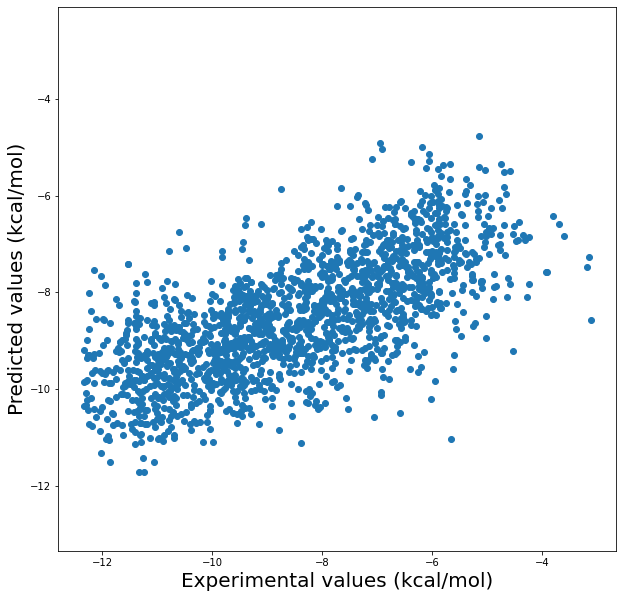

In [77]:
# Predict energy for test set
observed_pred = predict(model, likelihood, X_test_fps)

print('R2   : %.3f' % pearsonr(y_test, observed_pred.mean.numpy())[0]**2)
print('RMSD : %.3f kcal/mol' % rmsd(y_test, observed_pred.mean.numpy()))

# Plot results
plot(y_test.numpy(), observed_pred.mean.numpy(), fig_filename='correlation_exp_pred_morgan_fps_cosine_mhc-i_cleaned.png')

R2   : 0.403
RMSD : 1.546 kcal/mol


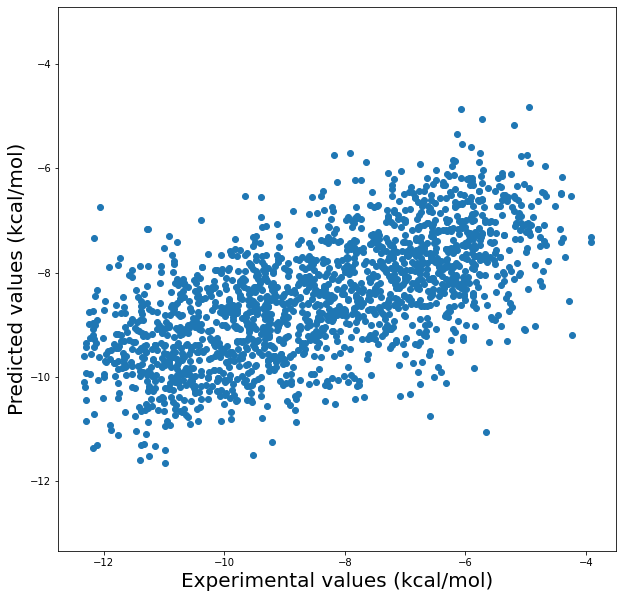

In [100]:
# Predict energy for test set
observed_pred = predict(model, likelihood, X_test_fps)

print('R2   : %.3f' % pearsonr(y_test, observed_pred.mean.numpy())[0]**2)
print('RMSD : %.3f kcal/mol' % rmsd(y_test, observed_pred.mean.numpy()))

# Plot results
plot(y_test.numpy(), observed_pred.mean.numpy(), fig_filename='correlation_exp_pred_morgan_fps_1024_cosine_mhc-i_cleaned.png')

R2   : 0.503
RMSD : 1.418 kcal/mol


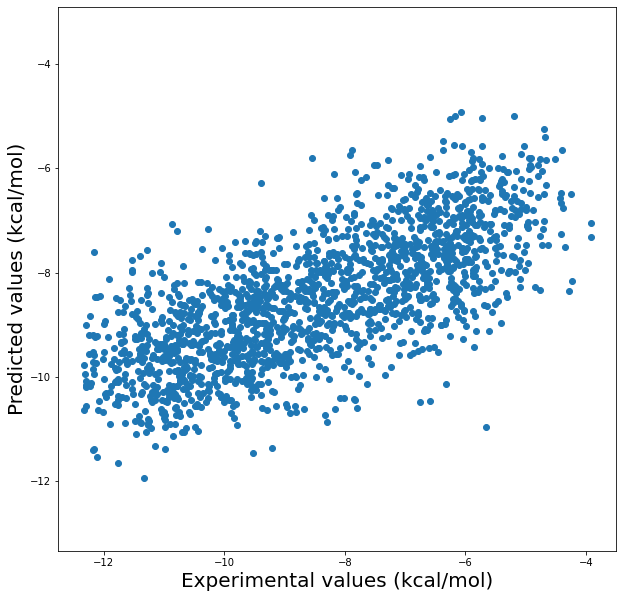

In [105]:
# Predict energy for test set
observed_pred = predict(model, likelihood, X_test_fps)

print('R2   : %.3f' % pearsonr(y_test, observed_pred.mean.numpy())[0]**2)
print('RMSD : %.3f kcal/mol' % rmsd(y_test, observed_pred.mean.numpy()))

# Plot results
plot(y_test.numpy(), observed_pred.mean.numpy(), fig_filename='correlation_exp_pred_morgan_fps_4096_cosine_mhc-i_cleaned.png')

### Morgan Fingerprint + Tanimoto similarity kernel

In [106]:
class TanimotoSimilarityKernel(gpytorch.kernels.Kernel):
    # the sequence kernel is stationary
    is_stationary = True     

    # this is the kernel function
    def forward(self, x1, x2, **params):
        x1s = torch.sum(torch.square(x1), dim=-1)
        x2s = torch.sum(torch.square(x2), dim=-1)
        product = torch.mm(x1, x2.transpose(1, 0))
        denominator = torch.add(x2s, x1s[:, None]) - product
        sim_mt = product / denominator
        return sim_mt

    
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = TanimotoSimilarityKernel()

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    
    
# Wrap training, prediction and plotting from the ExactGP-Tutorial into a function,
# so that we do not have to repeat the code later on
def train(model, likelihood, train_x, train_y, training_iter=100):
    # Find optimal model hyperparameters
    model.train()
    likelihood.train()

    # Use the adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    for i in range(training_iter):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(train_x)
        # Calc loss and backprop gradients
        loss = -mll(output, train_y)
        loss.backward()
        
        print('Iter %04d/%d - Loss: %.3f   noise: %.3f' % (
            i + 1, training_iter, loss.item(),
            model.likelihood.noise.item()
        ))
        
        optimizer.step()

In [107]:
# Initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(X_train_fps, y_train, likelihood)

# Train GP model
train(model, likelihood, X_train_fps, y_train, training_iter=1000)

Iter 0001/1000 - Loss: 1.969   noise: 0.693
Iter 0002/1000 - Loss: 1.955   noise: 0.744
Iter 0003/1000 - Loss: 1.946   noise: 0.798
Iter 0004/1000 - Loss: 1.937   noise: 0.853
Iter 0005/1000 - Loss: 1.931   noise: 0.910
Iter 0006/1000 - Loss: 1.923   noise: 0.969
Iter 0007/1000 - Loss: 1.919   noise: 1.028
Iter 0008/1000 - Loss: 1.912   noise: 1.087
Iter 0009/1000 - Loss: 1.909   noise: 1.146
Iter 0010/1000 - Loss: 1.907   noise: 1.204
Iter 0011/1000 - Loss: 1.903   noise: 1.260
Iter 0012/1000 - Loss: 1.902   noise: 1.314
Iter 0013/1000 - Loss: 1.899   noise: 1.364
Iter 0014/1000 - Loss: 1.898   noise: 1.411
Iter 0015/1000 - Loss: 1.895   noise: 1.454
Iter 0016/1000 - Loss: 1.894   noise: 1.493
Iter 0017/1000 - Loss: 1.893   noise: 1.527
Iter 0018/1000 - Loss: 1.896   noise: 1.556
Iter 0019/1000 - Loss: 1.894   noise: 1.580
Iter 0020/1000 - Loss: 1.894   noise: 1.599
Iter 0021/1000 - Loss: 1.892   noise: 1.614
Iter 0022/1000 - Loss: 1.891   noise: 1.624
Iter 0023/1000 - Loss: 1.891   n

Iter 0188/1000 - Loss: 1.863   noise: 1.432
Iter 0189/1000 - Loss: 1.864   noise: 1.432
Iter 0190/1000 - Loss: 1.864   noise: 1.431
Iter 0191/1000 - Loss: 1.864   noise: 1.430
Iter 0192/1000 - Loss: 1.864   noise: 1.430
Iter 0193/1000 - Loss: 1.864   noise: 1.428
Iter 0194/1000 - Loss: 1.864   noise: 1.424
Iter 0195/1000 - Loss: 1.865   noise: 1.421
Iter 0196/1000 - Loss: 1.863   noise: 1.417
Iter 0197/1000 - Loss: 1.864   noise: 1.414
Iter 0198/1000 - Loss: 1.863   noise: 1.411
Iter 0199/1000 - Loss: 1.865   noise: 1.408
Iter 0200/1000 - Loss: 1.864   noise: 1.406
Iter 0201/1000 - Loss: 1.865   noise: 1.405
Iter 0202/1000 - Loss: 1.865   noise: 1.403
Iter 0203/1000 - Loss: 1.863   noise: 1.402
Iter 0204/1000 - Loss: 1.864   noise: 1.403
Iter 0205/1000 - Loss: 1.864   noise: 1.405
Iter 0206/1000 - Loss: 1.865   noise: 1.407
Iter 0207/1000 - Loss: 1.863   noise: 1.409
Iter 0208/1000 - Loss: 1.862   noise: 1.410
Iter 0209/1000 - Loss: 1.865   noise: 1.412
Iter 0210/1000 - Loss: 1.864   n

Iter 0375/1000 - Loss: 1.865   noise: 1.425
Iter 0376/1000 - Loss: 1.864   noise: 1.423
Iter 0377/1000 - Loss: 1.864   noise: 1.423
Iter 0378/1000 - Loss: 1.864   noise: 1.423
Iter 0379/1000 - Loss: 1.864   noise: 1.422
Iter 0380/1000 - Loss: 1.863   noise: 1.421
Iter 0381/1000 - Loss: 1.862   noise: 1.419
Iter 0382/1000 - Loss: 1.864   noise: 1.417
Iter 0383/1000 - Loss: 1.863   noise: 1.417
Iter 0384/1000 - Loss: 1.866   noise: 1.415
Iter 0385/1000 - Loss: 1.863   noise: 1.413
Iter 0386/1000 - Loss: 1.863   noise: 1.414
Iter 0387/1000 - Loss: 1.865   noise: 1.414
Iter 0388/1000 - Loss: 1.861   noise: 1.416
Iter 0389/1000 - Loss: 1.864   noise: 1.417
Iter 0390/1000 - Loss: 1.864   noise: 1.417
Iter 0391/1000 - Loss: 1.865   noise: 1.419
Iter 0392/1000 - Loss: 1.864   noise: 1.422
Iter 0393/1000 - Loss: 1.863   noise: 1.422
Iter 0394/1000 - Loss: 1.864   noise: 1.421
Iter 0395/1000 - Loss: 1.864   noise: 1.420
Iter 0396/1000 - Loss: 1.864   noise: 1.421
Iter 0397/1000 - Loss: 1.864   n

Iter 0562/1000 - Loss: 1.862   noise: 1.421
Iter 0563/1000 - Loss: 1.864   noise: 1.413
Iter 0564/1000 - Loss: 1.864   noise: 1.406
Iter 0565/1000 - Loss: 1.865   noise: 1.402
Iter 0566/1000 - Loss: 1.864   noise: 1.398
Iter 0567/1000 - Loss: 1.862   noise: 1.395
Iter 0568/1000 - Loss: 1.865   noise: 1.395
Iter 0569/1000 - Loss: 1.864   noise: 1.395
Iter 0570/1000 - Loss: 1.863   noise: 1.397
Iter 0571/1000 - Loss: 1.864   noise: 1.401
Iter 0572/1000 - Loss: 1.864   noise: 1.406
Iter 0573/1000 - Loss: 1.865   noise: 1.411
Iter 0574/1000 - Loss: 1.863   noise: 1.416
Iter 0575/1000 - Loss: 1.864   noise: 1.417
Iter 0576/1000 - Loss: 1.863   noise: 1.418
Iter 0577/1000 - Loss: 1.863   noise: 1.419
Iter 0578/1000 - Loss: 1.864   noise: 1.419
Iter 0579/1000 - Loss: 1.863   noise: 1.418
Iter 0580/1000 - Loss: 1.863   noise: 1.417
Iter 0581/1000 - Loss: 1.864   noise: 1.414
Iter 0582/1000 - Loss: 1.864   noise: 1.410
Iter 0583/1000 - Loss: 1.864   noise: 1.409
Iter 0584/1000 - Loss: 1.865   n

Iter 0749/1000 - Loss: 1.864   noise: 1.439
Iter 0750/1000 - Loss: 1.864   noise: 1.439
Iter 0751/1000 - Loss: 1.865   noise: 1.436
Iter 0752/1000 - Loss: 1.863   noise: 1.433
Iter 0753/1000 - Loss: 1.862   noise: 1.429
Iter 0754/1000 - Loss: 1.862   noise: 1.424
Iter 0755/1000 - Loss: 1.865   noise: 1.420
Iter 0756/1000 - Loss: 1.864   noise: 1.416
Iter 0757/1000 - Loss: 1.863   noise: 1.413
Iter 0758/1000 - Loss: 1.863   noise: 1.411
Iter 0759/1000 - Loss: 1.863   noise: 1.407
Iter 0760/1000 - Loss: 1.863   noise: 1.403
Iter 0761/1000 - Loss: 1.864   noise: 1.399
Iter 0762/1000 - Loss: 1.865   noise: 1.400
Iter 0763/1000 - Loss: 1.863   noise: 1.405
Iter 0764/1000 - Loss: 1.864   noise: 1.411
Iter 0765/1000 - Loss: 1.863   noise: 1.415
Iter 0766/1000 - Loss: 1.864   noise: 1.418
Iter 0767/1000 - Loss: 1.864   noise: 1.422
Iter 0768/1000 - Loss: 1.864   noise: 1.424
Iter 0769/1000 - Loss: 1.863   noise: 1.423
Iter 0770/1000 - Loss: 1.863   noise: 1.423
Iter 0771/1000 - Loss: 1.863   n

Iter 0936/1000 - Loss: 1.863   noise: 1.438
Iter 0937/1000 - Loss: 1.864   noise: 1.438
Iter 0938/1000 - Loss: 1.866   noise: 1.433
Iter 0939/1000 - Loss: 1.865   noise: 1.428
Iter 0940/1000 - Loss: 1.864   noise: 1.423
Iter 0941/1000 - Loss: 1.864   noise: 1.411
Iter 0942/1000 - Loss: 1.863   noise: 1.403
Iter 0943/1000 - Loss: 1.863   noise: 1.397
Iter 0944/1000 - Loss: 1.863   noise: 1.391
Iter 0945/1000 - Loss: 1.864   noise: 1.388
Iter 0946/1000 - Loss: 1.863   noise: 1.390
Iter 0947/1000 - Loss: 1.864   noise: 1.394
Iter 0948/1000 - Loss: 1.865   noise: 1.398
Iter 0949/1000 - Loss: 1.863   noise: 1.404
Iter 0950/1000 - Loss: 1.864   noise: 1.411
Iter 0951/1000 - Loss: 1.863   noise: 1.419
Iter 0952/1000 - Loss: 1.864   noise: 1.425
Iter 0953/1000 - Loss: 1.866   noise: 1.432
Iter 0954/1000 - Loss: 1.866   noise: 1.439
Iter 0955/1000 - Loss: 1.864   noise: 1.442
Iter 0956/1000 - Loss: 1.865   noise: 1.441
Iter 0957/1000 - Loss: 1.863   noise: 1.440
Iter 0958/1000 - Loss: 1.862   n

R2   : 0.489
RMSD : 1.449 kcal/mol


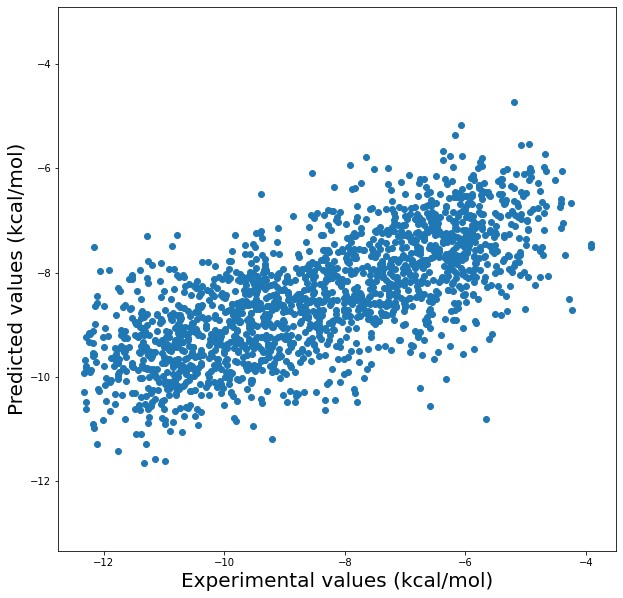

In [83]:
# Predict energy for test set
observed_pred = predict(model, likelihood, X_test_fps)
 
print('R2   : %.3f' % pearsonr(y_test, observed_pred.mean.numpy())[0]**2)
print('RMSD : %.3f kcal/mol' % rmsd(y_test, observed_pred.mean.numpy()))

# Plot results
plot(y_test.numpy(), observed_pred.mean.numpy(), fig_filename='correlation_exp_pred_morgan_fps_tanimoto_mhc-i_cleaned.png')

R2   : 0.515
RMSD : 1.417 kcal/mol


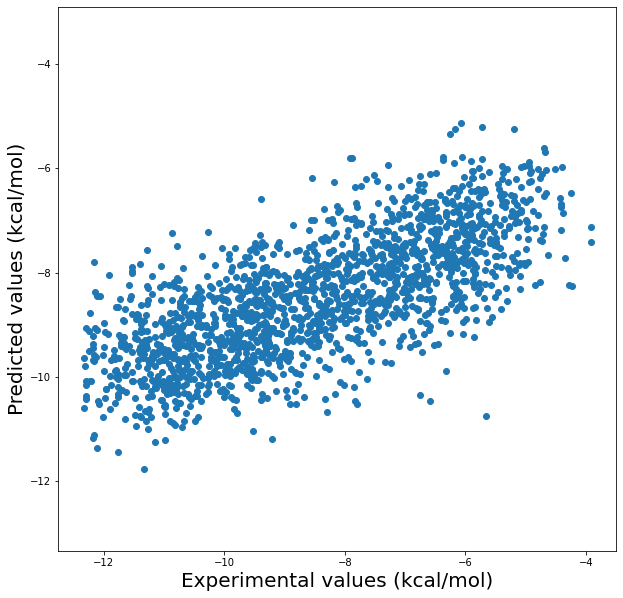

In [108]:
# Predict energy for test set
observed_pred = predict(model, likelihood, X_test_fps)
 
print('R2   : %.3f' % pearsonr(y_test, observed_pred.mean.numpy())[0]**2)
print('RMSD : %.3f kcal/mol' % rmsd(y_test, observed_pred.mean.numpy()))

# Plot results
plot(y_test.numpy(), observed_pred.mean.numpy(), fig_filename='correlation_exp_pred_morgan_fps_4096_tanimoto_mhc-i_cleaned.png')

## MAP4 fingerprint + Tanimoto similarity kernel

In [89]:
MAP4_unf = MAP4Calculator(dimensions=2048, is_folded=True)

X_train_fps = MAP4_unf.calculate_many([Chem.rdmolfiles.MolFromFASTA(s) for s in X_train])
X_test_fps = MAP4_unf.calculate_many([Chem.rdmolfiles.MolFromFASTA(s) for s in X_test])

In [92]:
X_train_fps = torch.from_numpy(np.array(X_train_fps)).float()
X_test_fps = torch.from_numpy(np.array(X_test_fps)).float()

In [94]:
# Initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(X_train_fps, y_train, likelihood)

# Train GP model
train(model, likelihood, X_train_fps, y_train, training_iter=1000)

Iter 0001/1000 - Loss: 2.119   noise: 0.693
Iter 0002/1000 - Loss: 2.087   noise: 0.744
Iter 0003/1000 - Loss: 2.055   noise: 0.798
Iter 0004/1000 - Loss: 2.026   noise: 0.853
Iter 0005/1000 - Loss: 2.003   noise: 0.911
Iter 0006/1000 - Loss: 1.981   noise: 0.969
Iter 0007/1000 - Loss: 1.965   noise: 1.028
Iter 0008/1000 - Loss: 1.950   noise: 1.088
Iter 0009/1000 - Loss: 1.938   noise: 1.148
Iter 0010/1000 - Loss: 1.926   noise: 1.208
Iter 0011/1000 - Loss: 1.918   noise: 1.267
Iter 0012/1000 - Loss: 1.910   noise: 1.326
Iter 0013/1000 - Loss: 1.905   noise: 1.383
Iter 0014/1000 - Loss: 1.900   noise: 1.438
Iter 0015/1000 - Loss: 1.896   noise: 1.492
Iter 0016/1000 - Loss: 1.893   noise: 1.543
Iter 0017/1000 - Loss: 1.892   noise: 1.592
Iter 0018/1000 - Loss: 1.890   noise: 1.639
Iter 0019/1000 - Loss: 1.888   noise: 1.683
Iter 0020/1000 - Loss: 1.886   noise: 1.725
Iter 0021/1000 - Loss: 1.885   noise: 1.764
Iter 0022/1000 - Loss: 1.887   noise: 1.801
Iter 0023/1000 - Loss: 1.884   n

Iter 0188/1000 - Loss: 1.881   noise: 1.893
Iter 0189/1000 - Loss: 1.880   noise: 1.894
Iter 0190/1000 - Loss: 1.880   noise: 1.894
Iter 0191/1000 - Loss: 1.881   noise: 1.893
Iter 0192/1000 - Loss: 1.881   noise: 1.893
Iter 0193/1000 - Loss: 1.881   noise: 1.893
Iter 0194/1000 - Loss: 1.880   noise: 1.892
Iter 0195/1000 - Loss: 1.880   noise: 1.892
Iter 0196/1000 - Loss: 1.881   noise: 1.892
Iter 0197/1000 - Loss: 1.880   noise: 1.892
Iter 0198/1000 - Loss: 1.879   noise: 1.892
Iter 0199/1000 - Loss: 1.880   noise: 1.891
Iter 0200/1000 - Loss: 1.880   noise: 1.891
Iter 0201/1000 - Loss: 1.881   noise: 1.891
Iter 0202/1000 - Loss: 1.881   noise: 1.890
Iter 0203/1000 - Loss: 1.880   noise: 1.890
Iter 0204/1000 - Loss: 1.880   noise: 1.890
Iter 0205/1000 - Loss: 1.880   noise: 1.890
Iter 0206/1000 - Loss: 1.880   noise: 1.890
Iter 0207/1000 - Loss: 1.882   noise: 1.890
Iter 0208/1000 - Loss: 1.880   noise: 1.890
Iter 0209/1000 - Loss: 1.880   noise: 1.890
Iter 0210/1000 - Loss: 1.881   n

Iter 0375/1000 - Loss: 1.881   noise: 1.891
Iter 0376/1000 - Loss: 1.879   noise: 1.891
Iter 0377/1000 - Loss: 1.881   noise: 1.890
Iter 0378/1000 - Loss: 1.880   noise: 1.890
Iter 0379/1000 - Loss: 1.880   noise: 1.890
Iter 0380/1000 - Loss: 1.880   noise: 1.889
Iter 0381/1000 - Loss: 1.880   noise: 1.888
Iter 0382/1000 - Loss: 1.881   noise: 1.887
Iter 0383/1000 - Loss: 1.881   noise: 1.886
Iter 0384/1000 - Loss: 1.881   noise: 1.886
Iter 0385/1000 - Loss: 1.880   noise: 1.887
Iter 0386/1000 - Loss: 1.879   noise: 1.887
Iter 0387/1000 - Loss: 1.881   noise: 1.886
Iter 0388/1000 - Loss: 1.881   noise: 1.886
Iter 0389/1000 - Loss: 1.880   noise: 1.886
Iter 0390/1000 - Loss: 1.879   noise: 1.885
Iter 0391/1000 - Loss: 1.880   noise: 1.885
Iter 0392/1000 - Loss: 1.882   noise: 1.885
Iter 0393/1000 - Loss: 1.879   noise: 1.885
Iter 0394/1000 - Loss: 1.880   noise: 1.885
Iter 0395/1000 - Loss: 1.880   noise: 1.884
Iter 0396/1000 - Loss: 1.880   noise: 1.884
Iter 0397/1000 - Loss: 1.881   n

Iter 0562/1000 - Loss: 1.881   noise: 1.891
Iter 0563/1000 - Loss: 1.880   noise: 1.891
Iter 0564/1000 - Loss: 1.881   noise: 1.891
Iter 0565/1000 - Loss: 1.881   noise: 1.892
Iter 0566/1000 - Loss: 1.880   noise: 1.894
Iter 0567/1000 - Loss: 1.880   noise: 1.894
Iter 0568/1000 - Loss: 1.880   noise: 1.893
Iter 0569/1000 - Loss: 1.881   noise: 1.894
Iter 0570/1000 - Loss: 1.881   noise: 1.893
Iter 0571/1000 - Loss: 1.880   noise: 1.894
Iter 0572/1000 - Loss: 1.879   noise: 1.894
Iter 0573/1000 - Loss: 1.881   noise: 1.894
Iter 0574/1000 - Loss: 1.880   noise: 1.894
Iter 0575/1000 - Loss: 1.881   noise: 1.894
Iter 0576/1000 - Loss: 1.881   noise: 1.895
Iter 0577/1000 - Loss: 1.880   noise: 1.894
Iter 0578/1000 - Loss: 1.882   noise: 1.894
Iter 0579/1000 - Loss: 1.881   noise: 1.894
Iter 0580/1000 - Loss: 1.880   noise: 1.895
Iter 0581/1000 - Loss: 1.880   noise: 1.895
Iter 0582/1000 - Loss: 1.880   noise: 1.894
Iter 0583/1000 - Loss: 1.881   noise: 1.894
Iter 0584/1000 - Loss: 1.881   n

Iter 0749/1000 - Loss: 1.880   noise: 1.894
Iter 0750/1000 - Loss: 1.881   noise: 1.894
Iter 0751/1000 - Loss: 1.881   noise: 1.894
Iter 0752/1000 - Loss: 1.881   noise: 1.894
Iter 0753/1000 - Loss: 1.880   noise: 1.894
Iter 0754/1000 - Loss: 1.881   noise: 1.892
Iter 0755/1000 - Loss: 1.879   noise: 1.891
Iter 0756/1000 - Loss: 1.882   noise: 1.890
Iter 0757/1000 - Loss: 1.881   noise: 1.890
Iter 0758/1000 - Loss: 1.881   noise: 1.891
Iter 0759/1000 - Loss: 1.880   noise: 1.891
Iter 0760/1000 - Loss: 1.880   noise: 1.891
Iter 0761/1000 - Loss: 1.880   noise: 1.892
Iter 0762/1000 - Loss: 1.880   noise: 1.892
Iter 0763/1000 - Loss: 1.880   noise: 1.893
Iter 0764/1000 - Loss: 1.881   noise: 1.894
Iter 0765/1000 - Loss: 1.880   noise: 1.896
Iter 0766/1000 - Loss: 1.879   noise: 1.897
Iter 0767/1000 - Loss: 1.881   noise: 1.897
Iter 0768/1000 - Loss: 1.881   noise: 1.897
Iter 0769/1000 - Loss: 1.881   noise: 1.897
Iter 0770/1000 - Loss: 1.880   noise: 1.897
Iter 0771/1000 - Loss: 1.880   n

Iter 0936/1000 - Loss: 1.881   noise: 1.882
Iter 0937/1000 - Loss: 1.880   noise: 1.882
Iter 0938/1000 - Loss: 1.881   noise: 1.882
Iter 0939/1000 - Loss: 1.881   noise: 1.882
Iter 0940/1000 - Loss: 1.880   noise: 1.882
Iter 0941/1000 - Loss: 1.880   noise: 1.884
Iter 0942/1000 - Loss: 1.881   noise: 1.885
Iter 0943/1000 - Loss: 1.881   noise: 1.886
Iter 0944/1000 - Loss: 1.882   noise: 1.887
Iter 0945/1000 - Loss: 1.882   noise: 1.887
Iter 0946/1000 - Loss: 1.881   noise: 1.887
Iter 0947/1000 - Loss: 1.881   noise: 1.887
Iter 0948/1000 - Loss: 1.880   noise: 1.887
Iter 0949/1000 - Loss: 1.880   noise: 1.888
Iter 0950/1000 - Loss: 1.880   noise: 1.890
Iter 0951/1000 - Loss: 1.881   noise: 1.891
Iter 0952/1000 - Loss: 1.880   noise: 1.891
Iter 0953/1000 - Loss: 1.879   noise: 1.892
Iter 0954/1000 - Loss: 1.881   noise: 1.890
Iter 0955/1000 - Loss: 1.880   noise: 1.888
Iter 0956/1000 - Loss: 1.881   noise: 1.887
Iter 0957/1000 - Loss: 1.880   noise: 1.886
Iter 0958/1000 - Loss: 1.881   n

R2   : 0.511
RMSD : 1.442 kcal/mol


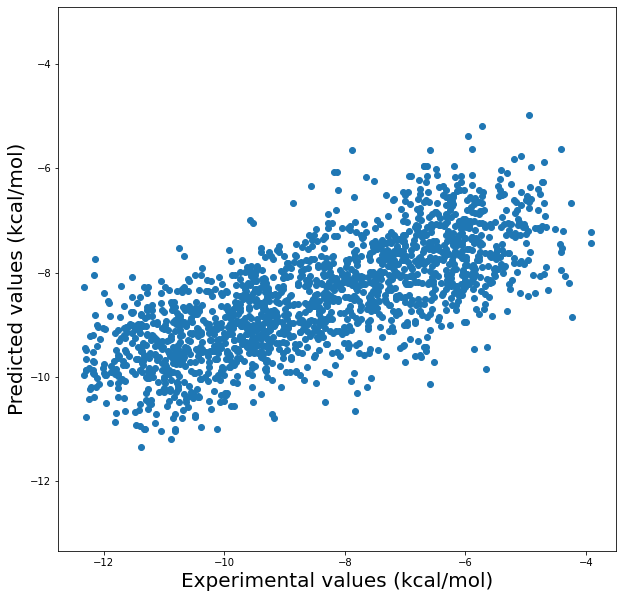

In [95]:
# Predict energy for test set
observed_pred = predict(model, likelihood, X_test_fps)
 
print('R2   : %.3f' % pearsonr(y_test, observed_pred.mean.numpy())[0]**2)
print('RMSD : %.3f kcal/mol' % rmsd(y_test, observed_pred.mean.numpy()))

# Plot results
plot(y_test.numpy(), observed_pred.mean.numpy(), fig_filename='correlation_exp_pred_MAP4_fps_tanimoto_mhc-i_cleaned.png')